<br><font color='green'>
## ch.1 Libraries, Read data, Simple Preprocessing

### Libraries

In [1]:
# basic 

import pandas as pd
import numpy as np
import datetime, time
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50, 'display.max_rows', 200)


# plot

import seaborn as sns
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
%matplotlib inline

import platform
your_os = platform.system()
if your_os == 'Linux':
    rc('font', family='NanumGothic')
elif your_os == 'Windows':
    ttf = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=ttf).get_name()
    rc('font', family=font_name)
elif your_os == 'Darwin':
    rc('font', family='AppleGothic')
rc('axes', unicode_minus=False)


# models
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from bayes_opt import BayesianOptimization
from sklearn.ensemble import VotingClassifier
from vecstack import StackingTransformer
from vecstack import stacking

## Read Transactions & Simple Preprocessing

##### Read transactions

In [165]:
X_train = pd.read_csv('X_train.csv', encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949')
tr = pd.merge(X_train, y_train, on='cust_id')
tr = tr[['cust_id', 'gender', 'tran_date', 'store_nm','goods_id','gds_grp_nm','gds_grp_mclas_nm','amount']]

X_test = pd.read_csv('X_test.csv', encoding='cp949')
tr2 = X_test

trs = [tr, tr2]

In [ ]:
## 월, 일, 요일, 계절, (월초, 월중, 월말) 칼럼 추가
for i in trs:

    i['month'] = i['tran_date'].agg(lambda x: pd.to_datetime(x).month)
    i['day'] = i['tran_date'].agg(lambda x: pd.to_datetime(x).day)
    i['date'] = i['tran_date'].agg(lambda x: ('월', '화', '수', '목', '금', '토', '일')[pd.to_datetime(x).weekday()])
    i['season'] = i['month'].agg(lambda x: 'spring' if x in [3,4,5] else 'summer' if x in [6,7,8] else 'fall' if x in [9,10,11] else 'winter')
    i['month_when'] = i['day'].agg(lambda x: '0to10' if x in list(range(1,11)) else '11to20' if x in list(range(11,21)) else '21to31')
    

In [ ]:
## 가격대 추가
for i in trs:

    i['amount_range'] = pd.cut(i['amount'],
       bins=[-300000000,0, 99999, 199999, 299990, 399990, 499990, 699990,999990, 1999990, 4999990, 800000000 ],
      right = False,
      labels = ['환불금액', '10만원이하', '10만원이상 20만원미만', '20만원이상 30만원미만', '30만원이상 40만원미만', '40만원이상 50만원미만', '50만원이상 70만원미만', '70만원이상 100만원미만', '100만원이상 200만원미만', '200만원이상 500만원미만', '500만원이상'])

*파생변수를 저장할 빈 리스트를 만든다.*

In [ ]:
features = [] # 생성된 모든 데이터프레임을 담음
features1 = [] # features에서 train에 해당 되는 피쳐를 담음
features2 = [] # features에서 test에 해당 되는 피쳐를 담음

<br><font color='green'>
## ch.2 Features

#### 데이터 불균형 확인
 - 각각의 성별을 구분할 수 있도록 하는 피쳐 생성
 - 특히 남성의 수가 적으므로 남성을 구분하는 피쳐일수록 좋음

In [ ]:
temp = len(tr.query('gender == 0'))/ len(tr.query('gender == 1'))
print(f'여성의 데이터 수가 남성보다 {temp:.4}배 더 많다.')

In [ ]:
f,ax = plt.subplots(1, 2, figsize=(10, 5), dpi=80)
tr.groupby('gender')['cust_id'].nunique().plot(kind='pie', autopct='%.2f%%', explode=(0,0.02), ax=ax[0])
ax[0].set_title('데이터 내의 남/녀 비율')
sns.countplot(data=tr, x='amount_range', hue='gender', ax=ax[1])
ax[1].set_title('구매 양상: 모든 구매금액대에서 여성의 수가 더 많음')
for item in ax[1].get_xticklabels():
       item.set_rotation(90)
# plt.axis('equal')
plt.tight_layout()
plt.show()

## 1차 생성 features


### 1. 가격적 관점

 만든 피쳐들
   - 년 총 구매금액에 따른 등급, 가격 선호도 
   - 총 구매액,구매건수,최대구매액, 평균 구매액
   - 환불금액, 환불건수, 내점 당 구매액, 구매건수
   

<font color = 'blue'> 년 총 구매금액에 따른 등급 (실제 롯데백화점 등급 기준 적용)

 - 롯데백화점 MVG 조건(2020년 기준)
         - 해당하지 않는 고객들은 silver로 설정 -> 10
         - 400만원 이상: Vip -> 20
         - 800만원 이상: Vip+ -> 30
         - 1800~2000만원이상: MVG-Ace  -> 40
         - 4000만원이상: MVG-Crown -> 50
         - 6000만원이상: MVG-Prestige -> 60
         - 1억이상: LENITH -> 70

In [ ]:
# 나누는 함수 정의
def divide_class(x):
    if 4000000<= x < 8000000:
        return 200
    elif 8000000<= x < 18000000:
        return 300
    elif 18000000<= x <40000000:
        return 400
    elif 40000000<= x <60000000:
        return 500
    elif 60000000<= x <100000000:
        return 600
    elif x>= 100000000:
        return 700
    else:
        return 100

for i in trs:
    
    temp_amountdf = i.groupby('cust_id')['amount'].sum().reset_index()

    temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

    f = temp_amountdf[['cust_id', 'class']]

    features.append(f); f

In [ ]:
# vip고객을 구분하는 피쳐 생성 
temp_amountdf = tr.groupby('cust_id')['amount'].sum().reset_index()

temp_amountdf['class'] = temp_amountdf['amount'].agg(divide_class)

f = temp_amountdf[['cust_id', 'class']]

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='class', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['class'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['class'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'> 가격 선호도 
    - 채택x

In [ ]:
f = tr.groupby('cust_id')['amount_range'].agg([('prefer_amount', lambda x: x.value_counts().index[0])]).reset_index()

f.prefer_amount = f.prefer_amount.map({'환불금액': 0, '10만원이하': 1, '10만원이상 20만원미만':2, '20만원이상 30만원미만':3,'30만원이상 40만원미만':4, '40만원이상 50만원미만':5, '50만원이상 70만원미만': 6, '70만원이상 100만원미만':7, '100만원이상 200만원미만':8, '200만원이상 500만원미만':9, '500만원이상': 10})

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='prefer_amount', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['prefer_amount'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['prefer_amount'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

총구매액

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('total_amount',np.sum), ]).reset_index()

    bins2 =  [i*10000000 for i in range(235)]
    f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

    f = f.fillna(0)
    f = f.drop('total_amount', axis=1)
    features.append(f); f
    

In [ ]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount',np.sum)]).reset_index()

f['gender'] = y_train['gender']

bins = [i*1000000 for i in range(2325)]
bins2 =  [i*10000000 for i in range(235)]
bins3 =  [i*100000000 for i in range(25)]

f['total_amount_range1'] = pd.cut(f.total_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_range2'] = pd.cut(f.total_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_range3'] = pd.cut(f.total_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_range3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

구매건수

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size), ]).reset_index()
    
    bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]
    f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])
    
    f = f.drop('num_of_purchase', axis=1)
    f = f.fillna(10)
    features.append(f); f  

In [ ]:
f = tr.groupby('cust_id')['amount'].agg([('num_of_purchase', np.size)]).reset_index()

f['gender'] = y_train['gender']

bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 300, 450, 600, 750, 900, 1050, 1200, 1350, 1500]

f['purchase_count'] = pd.cut(f.num_of_purchase,bins= bins,labels=[i*10 for i in range(1,len(bins))])

figure, ax = plt.subplots(1, 2, figsize=(10, 5))
sns.countplot(data=f, x='purchase_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0')['purchase_count'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['purchase_count'], ax=ax[1], label='남성')
plt.tight_layout()
plt.show()

<font color = 'blue'>

평균구매액

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([
        ('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()
    
    f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

    bins = [i*100000 for i in range(1545)]
    f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])

    
    f = f.drop('total_amount_avg', axis=1)
    f = f.fillna(0)
    features.append(f); f  

In [ ]:
f = tr.groupby('cust_id')['amount'].agg([('total_amount_avg', lambda x: np.round(np.mean(x))),]).reset_index()

f.total_amount_avg = f.total_amount_avg.apply(lambda x: 0 if x<0 else x)

f['gender'] = y_train['gender']

bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['total_amount_avg_range1'] = pd.cut(f.total_amount_avg,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_amount_avg_range2'] = pd.cut(f.total_amount_avg,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['total_amount_avg_range3'] = pd.cut(f.total_amount_avg, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['total_amount_avg_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_amount_avg_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['total_amount_avg_range2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='total_amount_avg_range3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>

 최대구매액

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['amount'].agg([('max_amount', np.max),]).reset_index()
    

    bins2  = [i*10000000 for i in range(71)]
    f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])
    
    
    f = f.drop('max_amount', axis=1)
    f.max_amount_range2 = f['max_amount_range2'].fillna(1)    
    features.append(f); f  

In [ ]:
f = tr.groupby('cust_id')['amount'].agg([ ('max_amount', np.max),]).reset_index()

f['gender'] = y_train['gender']


bins = [i*1000000 for i in range(710)]
bins2  = [i*10000000 for i in range(71)]

f['max_amount_range1'] = pd.cut(f.max_amount, bins= bins,labels=[i for i in range(1,len(bins))])
f['max_amount_range2'] = pd.cut(f.max_amount, bins= bins2,labels=[i for i in range(1,len(bins2))])


figure, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['max_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['max_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['max_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
plt.tight_layout()
plt.show()

<font color = 'blue'>총 환불금액
    - 채택 x

In [ ]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_amount', lambda x: x.sum() * -1),]).reset_index()

f['gender'] = y_train['gender']

In [ ]:
bins = [i*200000 for i in range(4358)]
bins2 =  [i*2000000 for i in range(436)]
bins3 =  [i*20000000 for i in range(44)]

f['refund_amount_range1'] = pd.cut(f.refund_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_amount_range2'] = pd.cut(f.refund_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['refund_amount_range3'] = pd.cut(f.refund_amount, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['refund_amount_range1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range1'], ax=ax[0], label='남성')
ax[0].set_title('20만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range2'], ax=ax[1], label='남성')
ax[1].set_title('200만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_amount_range3'], ax=ax[2], label='여성')
sns.kdeplot(f.query('gender==1')['refund_amount_range3'], ax=ax[2], label='남성')
ax[1].set_title('2000만원 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>환불건수
    - 채택 x

In [ ]:
f = tr[tr.amount < 0].groupby('cust_id')['amount'].agg([('refund_num', np.size)]).reset_index()

f['gender'] = y_train['gender']

In [ ]:
bins = [i for i in range(34)]
bins2 =  [i*2 for i in range(17)]

f['refund_num_1'] = pd.cut(f.refund_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['refund_num_2'] = pd.cut(f.refund_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='refund_num_1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='refund_num_2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['refund_num_1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['refund_num_2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['refund_num_2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매금액
    - 채택 x

In [ ]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
f = (tr.groupby('cust_id')['amount'].sum() / visits).reset_index().rename(columns={0 : "per_visit_amount"})
f.per_visit_amount = f.per_visit_amount.astype(int)
f['gender'] = y_train['gender']

In [ ]:
bins = [i*100000 for i in range(1545)]
bins2 =  [i*1000000 for i in range(155)]
bins3 =  [i*10000000 for i in range(15)]

f['per_visit_amount1'] = pd.cut(f.per_visit_amount,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_amount2'] = pd.cut(f.per_visit_amount,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per_visit_amount3'] = pd.cut(f.per_visit_amount,bins= bins3,labels=[i for i in range(0,len(bins3)-1)])


In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per_visit_amount1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount1'], ax=ax[0], label='남성')
ax[0].set_title('10만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_amount2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_amount2'], ax=ax[1], label='남성')
ax[1].set_title('100만원 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_amount3', hue='gender', ax=ax[2])
ax[2].set_title('1000만원 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'> 내점당 구매건수

In [ ]:
# 내점 당 구매액 = 총구매액 / 내점일수
for i in trs:
    
    visits = i.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수
    
    f = (i.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})
    
    f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))
    
    features.append(f); f

In [ ]:
visits = tr.groupby('cust_id')['tran_date'].agg(lambda x: x.nunique()) # 내점일수

f = (tr.groupby('cust_id')['amount'].size() / visits).reset_index().rename(columns={0 : "per_visit_pur_num"})

f.per_visit_pur_num = f.per_visit_pur_num.apply(lambda x: round(x))

f['gender'] = y_train['gender']

bins = [i for i in range(22)]
bins2 =  [i*2 for i in range(11)]

f['per_visit_pur_num1'] = pd.cut(f.per_visit_pur_num,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['per_visit_pur_num2'] = pd.cut(f.per_visit_pur_num,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='per_visit_pur_num1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='per_visit_pur_num2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['per_visit_pur_num1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per_visit_pur_num2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['per_visit_pur_num2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()


## ────────────────────────────────────────────────────────
### 2. 시간적 관점

 만든 피쳐들
   - 내점일수, 구매주기
   - 선호방문계절, 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)
   - 선호방문월, 방문비율, 구매비율, 구매건수
   - 월초, 월중, 월말 선호 방문때, 방문비율, 구매비율, 구매건수
   - 최근 3개월, 6개월, 12개월 구매금액, 구매건수
   - 선호방문요일, 방문비율, 구매비율, 구매건수
   - 주말방문비율, 고객별 주말구매건수

<font color = 'blue'> 내점일수

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([
        ('total_visit',lambda x: x.str[:10].nunique())]).reset_index()
    
    bins2 =  [i*2 for i in range(143)]
    f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    
    f = f.drop('total_visit', axis=1)
    f = f.fillna(0)
    features.append(f); f  

In [ ]:
f = tr.groupby('cust_id')['tran_date'].agg([('total_visit',lambda x: x.str[:10].nunique()),]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(285)]
bins2 =  [i*2 for i in range(143)]

f['total_visit1'] = pd.cut(f.total_visit,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['total_visit2'] = pd.cut(f.total_visit,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='total_visit1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='total_visit2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['total_visit1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['total_visit2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['total_visit2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'>
    구매주기

In [ ]:
for i in trs:
    f = i.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

    bins2 =  [i*2 for i in range(78)]
    f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])    
    
    f = f.drop('buying_cycle', axis=1) 
    f.buying_cycle2 = f['buying_cycle2'].fillna(0) 
    features.append(f); f  

In [ ]:
f = tr.groupby('cust_id')['tran_date'].agg([('buying_cycle', lambda x: int((x.astype('datetime64').max() - x.astype('datetime64').min()).days / x.str[:10].nunique()))]).reset_index()

f['gender'] = y_train['gender']

bins = [i for i in range(166)]
bins2 =  [i*2 for i in range(78)]

f['buying_cycle1'] = pd.cut(f.buying_cycle,bins= bins,labels=[i for i in range(0,len(bins)-1)])
f['buying_cycle2'] = pd.cut(f.buying_cycle,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(15, 5))
sns.countplot(data=f, x='buying_cycle1', hue='gender', ax=ax[0,0])
ax[0,0].set_title('1 단위로 묶었을 때')
sns.countplot(data=f, x='buying_cycle2', hue='gender', ax=ax[0,1])
ax[0,1].set_title('2 단위로 묶었을 때')

sns.kdeplot(f.query('gender==0')['buying_cycle1'], ax=ax[1,0], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle1'], ax=ax[1,0], label='남성')
ax[1,0].set_title('1 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['buying_cycle2'], ax=ax[1,1], label='여성')
sns.kdeplot(f.query('gender==1')['buying_cycle2'], ax=ax[1,1], label='남성')
ax[1,1].set_title('2 단위로 묶었을 때')

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문계절

In [ ]:
## 고객별 선호방문계절
for i in trs:
    f = i.groupby('cust_id')['season'].agg([
        ('perfer_season', lambda x: x.value_counts().index[0])
    ]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
    f.perfer_season = f.perfer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

    features.append(f); f

In [ ]:
## 고객별 선호방문계절
f = tr.groupby('cust_id')['season'].agg([('prefer_season', lambda x: x.value_counts().index[0])]).reset_index()

## spring은 0, summer는 1, fall은 2, winter는 3으로 바꿔주기
f.prefer_season = f.prefer_season.map({'spring': 0, 'summer':1, 'fall':2, 'winter':3})

f['gender'] = y_train['gender']

plt.figure(figsize=(7,4))
sns.kdeplot(f.query('gender==0').prefer_season, label = '여성')
sns.kdeplot(f.query('gender==1').prefer_season, label = '남성')
plt.xticks([0,1,2,3],['spring','summer','fall','winter'])
plt.title('사계절 중 선호하는 계절')
plt.show()

<font color = 'blue'> 계절별 구매비율(s:3to5, s:6to8, f:9to11, w:12to2)

In [ ]:
for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
        ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
        ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
        ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
    ]).reset_index()
    
    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['tran_date'].agg([
    ('spring_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([3,4,5]))),
    ('summer_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([6,7,8]))),
    ('fall_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([9,10,11]))),
    ('winter_pur_ratio', lambda x: np.mean( pd.to_datetime(x).dt.month.isin([1,2,12])))
]).reset_index()

f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(2, 2, figsize=(15, 7))
sns.kdeplot(f.query('gender==0').spring_pur_ratio, label = '여성', ax=ax[0,0])
sns.kdeplot(f.query('gender==1').spring_pur_ratio, label = '남성', ax=ax[0,0])
ax[0,0].set_title('spring')
ax[0,1].set_title('summer')
sns.kdeplot(f.query('gender==0').summer_pur_ratio, label = '여성', ax=ax[0,1])
sns.kdeplot(f.query('gender==1').summer_pur_ratio, label = '남성', ax=ax[0,1])
ax[1,0].set_title('fall')
sns.kdeplot(f.query('gender==0').fall_pur_ratio, label = '여성', ax=ax[1,0])
sns.kdeplot(f.query('gender==1').fall_pur_ratio, label = '남성', ax=ax[1,0])
ax[1,1].set_title('winter')
sns.kdeplot(f.query('gender==0').winter_pur_ratio, label = '여성', ax=ax[1,1])
sns.kdeplot(f.query('gender==1').winter_pur_ratio, label = '남성', ax=ax[1,1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 선호방문월

In [ ]:
## 선호방문월

for i in trs:
    
    f = i.groupby('cust_id')['month'].agg([
        ('prefer_month', lambda x: x.value_counts(1).index[0])
    ]).reset_index()

    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['month'].agg([('prefer_month', lambda x: x.value_counts(1).index[0])]).reset_index()

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month', hue='gender', ax=ax[0])
ax[0].set_title('선호방문월')

sns.kdeplot(f.query('gender==0').prefer_month, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,13)])
plt.title('선호방문월')

plt.tight_layout()
plt.show()

<font color = 'blue'>월별 방문비율
    - 채택 x

In [ ]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
    
# 월별 방문일수
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

## 고객별 월별 방문비율
for i in range(len(temp_monthpivot.columns)):
    
     temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_visits
    
f = temp_monthpivot.reset_index()

f['gender'] = y_train['gender']


In [ ]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율
    - 12달 중 1월, 2월 그리고 9월을 피쳐로 채택

In [ ]:
## 월별 구매비율
for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월별 구매금액
    temp_monthpivot = pd.pivot_table(i, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthpivot.columns.tolist()
    newname = [str(i)+'_month_amount' for i in oldname]
    temp_monthpivot = temp_monthpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월별 구매금액비율
    for i in range(len(temp_monthpivot.columns)):
    
        temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
    f = temp_monthpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    f = f[['cust_id', '1_month_amount', '2_month_amount','9_month_amount']]
    features.append(f); f

In [ ]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월별 구매금액
temp_monthpivot = pd.pivot_table(tr, index='cust_id', columns='month', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월별 구매금액비율
for i in range(len(temp_monthpivot.columns)):
    
    temp_monthpivot.iloc[:,i] = temp_monthpivot.iloc[:,i] / total_amount
    
f = temp_monthpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']


In [ ]:
figure, ax = plt.subplots(2, 6, figsize=(15, 7))

for month in range(1,7):
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[0,month-1]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[0,month-1])
    ax[0,month-1].set_xlim(0,1)
    ax[0,month-1].set_title(f'{month}월')

temp = 0
for month in range(7,13):
    
    sns.kdeplot(f.query('gender==0')[month], label = '여성', ax=ax[1,temp]) 
    sns.kdeplot(f.query('gender==1')[month], label = '남성', ax=ax[1,temp])
    ax[1,temp].set_xlim(0,1)
    ax[1,temp].set_title(f'{month}월')
    temp += 1

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 선호 방문때
    - 채택x

In [ ]:
f = tr.groupby('cust_id')['month_when'].agg([('prefer_month_when', lambda x: x.value_counts().index[0])]).reset_index()

# 문자를 숫자로 바꿔주기: '0to10':0 ~ '21to31': 2
f.prefer_month_when = f.prefer_month_when.map({'0to10':0, '11to20': 1, '21to31':2})

f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.countplot(data=f, x='prefer_month_when', hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0').prefer_month_when, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_month_when, label = '남성', ax=ax[1])
plt.xticks([i for i in range(1,4)])


plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 방문비율


In [ ]:
## 고객별 월초, 월중, 월말 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
        
    # 고객별 월초, 월중, 월말 방문일수
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말 방문비율

    for i in range(len(temp_monthwhenpivot.columns)):
    
            temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
    f = temp_monthwhenpivot.reset_index()

    features.append(f); f

In [ ]:
# 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
        
# 고객별 월초, 월중, 월말 방문일수
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 고객별 월초, 월중, 월말 방문비율

for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_visits
    
f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']


In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매비율


In [ ]:
##고객별 월초, 월중, 월말 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    
    # 고객별 월초, 월중, 월말별 구매금액
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    # 고객별 월초, 월중, 월말별 구매금액비율
    for i in range(len(temp_monthwhenpivot.columns)):
    
        temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
    f = temp_monthwhenpivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

    features.append(f); f

In [ ]:
# 고객별 구매금액 총합
total_amount = tr.groupby('cust_id')['amount'].sum()
    
# 고객별 월초, 월중, 월말별 구매금액
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=sum, fill_value=0)

# 고객별 월초, 월중, 월말별 구매금액비율
for i in range(len(temp_monthwhenpivot.columns)):
    
    temp_monthwhenpivot.iloc[:,i] = temp_monthwhenpivot.iloc[:,i] / total_amount
    
f = temp_monthwhenpivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)

f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5))
sns.kdeplot(f.query('gender==0')['0to10'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
ax[0].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['11to20'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
ax[1].set_ylim(0,0.4)
sns.kdeplot(f.query('gender==0')['21to31'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31'], label = '남성', ax=ax[2])
ax[2].set_title('월말')
ax[2].set_ylim(0,0.4)
plt.tight_layout()
plt.show()

<font color = 'blue'>  월초, 월중, 월말 구매건수


In [ ]:
## 고객별 월초, 월중, 월말 구매건수

for i in trs:
    
    temp_monthwhenpivot = pd.pivot_table(i, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)
    
    
    
    # 칼럼명 변경화
    oldname = temp_monthwhenpivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_monthwhenpivot = temp_monthwhenpivot.rename(columns=dict(zip(oldname, newname)))

    f = temp_monthwhenpivot.reset_index()
    
    bins = [i*10 for i in range(57)]
    bins2 = [i*10 for i in range(65)]
    bins3 = [i*10 for i in range(67)]
    labels = [i for i in range(len(bins)-1)]
    labels2 = [i for i in range(len(bins2)-1)]
    labels3 = [i for i in range(len(bins3)-1)]
    f['0to10_10unit'] = pd.cut(f['0to10_buy'], bins=bins, labels = labels)
    f['11to20_20unit'] = pd.cut(f['11to20_buy'], bins=bins2, labels = labels2)
    f['21to31_30unit'] = pd.cut(f['21to31_buy'], bins=bins3, labels = labels3)
    f = f.drop('0to10_buy', axis=1) 
    f = f.drop('11to20_buy', axis=1) 
    f = f.drop('21to31_buy', axis=1) 
    f = f.fillna(0)

    features.append(f); f

In [ ]:
temp_monthwhenpivot = pd.pivot_table(tr, index='cust_id', columns='month_when', values='amount', aggfunc=np.size, fill_value=0)

f = temp_monthwhenpivot.reset_index()

f['gender'] = y_train['gender']

In [ ]:
bins = [i*10 for i in range(57)]
bins2 = [i*10 for i in range(65)]
bins3 = [i*10 for i in range(67)]
labels = [i for i in range(len(bins)-1)]
labels2 = [i for i in range(len(bins2)-1)]
labels3 = [i for i in range(len(bins3)-1)]
f['0to10_10unit'] = pd.cut(f['0to10'], bins=bins, labels = labels)
f['11to20_20unit'] = pd.cut(f['11to20'], bins=bins2, labels = labels2)
f['21to31_30unit'] = pd.cut(f['21to31'], bins=bins3, labels = labels3)

f = f.fillna(0)

In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(10, 5)) 
sns.kdeplot(f.query('gender==0')['0to10_10unit'], label = '여성', ax=ax[0]) 
sns.kdeplot(f.query('gender==1')['0to10_10unit'], label = '남성', ax=ax[0])
ax[0].set_title('월초')
sns.kdeplot(f.query('gender==0')['11to20_20unit'], label = '여성', ax=ax[1]) 
sns.kdeplot(f.query('gender==1')['11to20_20unit'], label = '남성', ax=ax[1])
ax[1].set_title('월중')
sns.kdeplot(f.query('gender==0')['21to31_30unit'], label = '여성', ax=ax[2]) 
sns.kdeplot(f.query('gender==1')['21to31_30unit'], label = '남성', ax=ax[2])
ax[2].set_title('월말')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매금액
    - 채택x


In [ ]:
start = str(pd.to_datetime(tr.tran_date.max()) - pd.offsets.MonthBegin(3))
f = tr.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
    ('per3month_amount_ratio', np.sum), 
    ('per3month_num_of_pur', np.size)
]).reset_index()

f['gender'] = y_train['gender']

In [ ]:
bins1 = [i*1000000 for i in range(762)]
bins2 =  [i*10000000 for i in range(77)]
bins3 =  [i*100000000 for i in range(8)]

f['per3month_amount_ratio1'] = pd.cut(f.per3month_amount_ratio, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_amount_ratio2'] = pd.cut(f.per3month_amount_ratio, bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f['per3month_amount_ratio3'] = pd.cut(f.per3month_amount_ratio, bins= bins3,labels=[i for i in range(0,len(bins3)-1)])

f = f.fillna(0)

In [ ]:
figure, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio1'], ax=ax[0], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio1'], ax=ax[0], label='남성')
ax[0].set_title('최대금액을 100만원 단위로 묶었을 때')
sns.kdeplot(f.query('gender==0')['per3month_amount_ratio2'], ax=ax[1], label='여성')
sns.kdeplot(f.query('gender==1')['per3month_amount_ratio2'], ax=ax[1], label='남성')
ax[1].set_title('최대금액을 1000만원 단위로 묶었을 때')
sns.countplot(data=f, x='per3month_amount_ratio3', hue='gender', ax=ax[2])
ax[2].set_title('최대금액을 1억 단위로 묶었을 때(밀도가 아니라 카운트임)')

plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 3개월 구매건수
    - 채택x

In [ ]:
bins1 = [i for i in range(528)]
bins2 = [i*2 for i in range(265)]
bins3 = [i*4 for i in range(133)]
bins4 = [i*5 for i in range(106)]

f['per3month_num_of_pur1'] = pd.cut(f.per3month_num_of_pur, bins= bins1,labels=[i for i in range(0,len(bins1)-1)])
f['per3month_num_of_pur2'] = pd.cut(f.per3month_num_of_pur, bins= bins2,labels=[i*2 for i in range(0,len(bins2)-1)])
f['per3month_num_of_pur3'] = pd.cut(f.per3month_num_of_pur, bins= bins3,labels=[i*4 for i in range(0,len(bins3)-1)])
f['per3month_num_of_pur4'] = pd.cut(f.per3month_num_of_pur, bins= bins4,labels=[i*5 for i in range(0,len(bins4)-1)])

In [ ]:
figure, ax = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):
    sns.kdeplot(f.query('gender==0')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='여성')
    sns.kdeplot(f.query('gender==1')[f'per3month_num_of_pur{i+1}'], ax=ax[i], label='남성')

    
plt.tight_layout()
plt.show()

<font color = 'blue'>  최근 12개월 구매금액, 구매건수
    - 앞에서 다룬 총 구매 금액과 총 구매건수와 겹치므로 피쳐제거

<font color = 'blue'> 선호방문요일


In [ ]:
## 선호방문요일

for i in trs:
    
    f = i.groupby('cust_id')['date'].agg([
        ('prefer_date', lambda x: x.value_counts().index[0])
    ]).reset_index()

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})


    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['date'].agg([('prefer_date', lambda x: x.value_counts().index[0])]).reset_index()

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
f.prefer_date = f.prefer_date.map({'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f['gender'] = y_train['gender']

figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='prefer_date', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').prefer_date, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').prefer_date, label = '남성', ax=ax[1])
plt.xticks([i for i in range(7)])

plt.tight_layout()
plt.show()

<font color = 'blue'> 방문비율


In [ ]:
## 요일별 방문비율

for i in trs:
    
    # 총 방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()

    # 고객별 요일별 방문일수
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_visits' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 방문비율
    
    for i in range(len(temp_datepivot.columns)):
        
            temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
    f = temp_datepivot.reset_index()
    f = f[['cust_id','0_visits','1_visits','2_visits','3_visits','4_visits', '5_visits']]

    features.append(f); f

In [ ]:
 # 총 방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()

# 고객별 요일별 방문일수
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 방문비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_visits
        
f = temp_datepivot.reset_index()
f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매비율


In [ ]:
## 고객별 요일별 구매비율

for i in trs:
    
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 요일별구매금액
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
    # 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_amount' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    # 고객별 요일별 구매금액비율
    for i in range(len(temp_datepivot.columns)):
        
        temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
    f = temp_datepivot.reset_index()
    f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
    features.append(f); f

In [ ]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 요일별구매금액
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=sum, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})
    
# 고객별 요일별 구매금액비율
for i in range(len(temp_datepivot.columns)):
        
    temp_datepivot.iloc[:,i] = temp_datepivot.iloc[:,i] / total_amount
        
f = temp_datepivot.reset_index()
f = f.replace([float('inf'), -float('inf')], [1, -1]).fillna(0)
f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
    ax[date].set_ylim(0,1)

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매건수


In [ ]:
## 고객별 요일별 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
    # 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
    temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

    ## 칼럼명 변경화
    oldname = temp_datepivot.columns.tolist()
    newname = [str(i)+'_buy' for i in oldname]
    temp_datepivot = temp_datepivot.rename(columns=dict(zip(oldname, newname)))
    
    f = temp_datepivot.reset_index()

    features.append(f); f

In [ ]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)
    
# 요일을 숫자로 바꿔주기: 월요일: 0 ~ 일요일: 6
temp_datepivot = temp_datepivot.rename(columns={'월':0,'화':1,'수':2,'목':3,'금':4,'토':5,'일':6})

f = temp_datepivot.reset_index()

f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 7, figsize=(15, 5))

for date in range(7):
    sns.kdeplot(f.query('gender==0')[date], label = '여성', ax=ax[date])
    sns.kdeplot(f.query('gender==1')[date], label = '남성', ax=ax[date])
    ax[date].set_title(f'{date}')
plt.tight_layout()
plt.show()

<font color = 'blue'> 주말방문비율

In [ ]:
## 주말방문비율

for i in trs:
    
    f = i.groupby('cust_id')['tran_date'].agg([
        ('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))
    ]).reset_index()
    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['tran_date'].agg([('weekend_visit_ratio', lambda x: np.mean(pd.to_datetime(x).dt.dayofweek>4))]).reset_index()

f['gender'] = y_train['gender']

plt.figure(figsize= (5,4))
sns.kdeplot(f.query('gender==0').weekend_visit_ratio, label = '여성')
sns.kdeplot(f.query('gender==1').weekend_visit_ratio, label = '남성')

plt.tight_layout()
plt.show()

<font color = 'blue'> 고객별 주말구매건수

In [ ]:
## 주말 구매건수

for i in trs:
    
    temp_datepivot = pd.pivot_table(i, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

    f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})
    
    
    bins2 =  [i*10 for i in range(63)]
    f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
    f.weekend_buy2 = f.weekend_buy2.fillna(0)
    f = f.drop('weekend_buy', axis=1)
    features.append(f); f

In [ ]:
temp_datepivot = pd.pivot_table(tr, index='cust_id', columns='date', values='amount', aggfunc=np.size, fill_value=0)

f = temp_datepivot[['토','일']].sum(axis=1).reset_index().rename(columns={0:'weekend_buy'})

f['gender'] = y_train['gender']

In [ ]:
bins2 =  [i*10 for i in range(63)]
f['weekend_buy2'] = pd.cut(f.weekend_buy,bins= bins2,labels=[i for i in range(0,len(bins2)-1)])
f.weekend_buy2 = f.weekend_buy2.fillna(0)

In [ ]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='weekend_buy2', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').weekend_buy2, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').weekend_buy2, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 3. 장소적 관점

만든 피쳐들
   - 주구매지점
   - 방문 지점의 수
   - 많이 방문한 지점들 best-12 순위별 구매금액비율, 구매건수

<font color = 'blue'> 주구매지점
    - 채택x

In [ ]:
f = tr.groupby('cust_id')['store_nm'].agg([('main_store', lambda x: x.value_counts().index[0])]).reset_index()

# 지점명 숫자로 바꿔주기
store_name = tr.store_nm.unique().tolist()
store_newname = [i for i in range(len(store_name))]
f.main_store = f.main_store.map(dict(zip(store_name, store_newname)))

f['gender'] = y_train['gender']

In [ ]:
figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='main_store', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_store, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_store, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'>  방문 지점의 수

In [ ]:
## 고객별 방문 지점의 수

for i in trs:

    f = i.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['store_nm'].nunique().reset_index().rename(columns={'store_nm':'stores_count'})

f['gender'] = y_train['gender']


figure, ax = plt.subplots(1, 2, figsize=(10, 3))

sns.countplot(data=f, x='stores_count', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').stores_count, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').stores_count, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 방문비율

 - top-12가 전체 24개의 점포중 91% 데이터를 차지한다

In [ ]:
## 전체의 90프로를 넘게 차지하는 12개의 점포 데이터

for i in trs:

    print(i.store_nm.value_counts()[:12].sum() / i.store_nm.value_counts().sum())

In [ ]:
top12store_all = []

for i in trs:
    
    ## top-12에 해당하는 지점들
    
    top12store = i.store_nm.value_counts()[:12].index.tolist()
    
    top12store_all.append(top12store)
    
top12store_train = top12store_all[0]; print(top12store_train)
top12store_test = top12store_all[1]; print(top12store_test)
print()
intersection_store = list(set(top12store_train).intersection(top12store_test)); print(intersection_store)
print('겹치는 지점 수: ', len(intersection_store))

In [ ]:
## intersection_store 방문비율

for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체방문일수
    total_visits = i.groupby('cust_id')['tran_date'].nunique()
    # 고객별 점포별 방문일수
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

    
    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_visits' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 방문비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    labels = [0, 0.2, 0.4, 0.6, 0.8]

    for i in range(11):
    
        f[f'{i}_visits{i}'] = pd.cut(f[f'{i*10}_visits'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_visits', axis=1)
    f = f.fillna(0)    
    features.append(f); f

In [ ]:
# 고객별 전체방문일수
total_visits = tr.groupby('cust_id')['tran_date'].nunique()
# 고객별 점포별 방문일수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='tran_date', aggfunc=(lambda x: x.nunique()), fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_department' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 방문비율
for i in range(len(temp_storepivot.columns)):
    
     temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_visits
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']


bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = [0, 0.2, 0.4, 0.6, 0.8]

for i in range(12):
    
    f[f'{i}_department{i}'] = pd.cut(f[f'{i*10}_department'], bins= bins, labels = labels)
    
    
figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_department0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_department0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_department0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()    
    
    

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매금액비율

In [ ]:
## intersection_store 구매금액비율

for i in trs:
    
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 구매금액 총합
    total_amount =  i.groupby('cust_id')['amount'].sum()
    # 고객별 점포별 구매금액
    temp_storepivot = pd.pivot_table(i.query('store_nm in @intersection_store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

    # 칼럼명 영문화
    engname = temp_storepivot.columns.tolist()
    newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
    temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

    # 고객별 점포별 구매금액비율
    for i in range(len(temp_storepivot.columns)):
    
        temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
    f = temp_storepivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)
    
    
    bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

    for i in range(11):
    
        f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)
        f = f.drop(f'{i*10}_amount_ratio', axis=1)
    f = f.fillna(0)    
    features.append(f); f

In [ ]:
# 고객별 구매금액 총합
total_amount =  tr.groupby('cust_id')['amount'].sum()
# 고객별 점포별 구매금액
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=sum, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_amount_ratio' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

# 고객별 점포별 구매금액비율
for i in range(len(temp_storepivot.columns)):
    
    temp_storepivot.iloc[:,i] = temp_storepivot.iloc[:,i] / total_amount
    
f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for i in range(12):
    
    f[f'{i}_amount_ratio{i}'] = pd.cut(f[f'{i*10}_amount_ratio'], bins= bins, labels = labels)

figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_amount_ratio0'], hue='gender', ax=ax[0])

sns.kdeplot(f.query('gender==0')['0_amount_ratio0'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_amount_ratio0'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

<font color = 'blue'> 많이 방문한 지점들 best-12 순위별 구매건수
    - 채택x

In [ ]:
# 고객별 점포별 구매건수
temp_storepivot = pd.pivot_table(tr.query('store_nm in @top12store'), index='cust_id', columns='store_nm', values='amount', aggfunc=np.size, fill_value=0)

# 칼럼명 영문화
engname = temp_storepivot.columns.tolist()
newname = [str(i*10)+'_num_of_pur' for i in range(len(engname))]
temp_storepivot = temp_storepivot.rename(columns=dict(zip(engname, newname)))

f = temp_storepivot.reset_index()
f['gender'] = y_train['gender']

In [ ]:
bins1 = [i*5 for i in range(195)]
bins2 = [i*10 for i in range(98)]
labels1 = [i for i in range(194)]
labels2 = [i for i in range(97)]
f[f'0_num_of_pur1'] = pd.cut(f['0_num_of_pur'], bins= bins1, labels = labels1)
f[f'0_num_of_pur2'] = pd.cut(f['0_num_of_pur'], bins= bins2, labels = labels2)

figure, ax = plt.subplots(1, 2, figsize = (8, 4))
sns.countplot(data=f, x=f['0_num_of_pur1'], hue='gender', ax=ax[0])
ax[0].set_ylim(0, 10)
sns.kdeplot(f.query('gender==0')['0_num_of_pur1'], label='여성', ax=ax[1])
sns.kdeplot(f.query('gender==1')['0_num_of_pur1'], label='남성', ax=ax[1])
    
plt.tight_layout()
plt.show()

## ────────────────────────────────────────────────────────

### 4.  제품적 관점

   - 구매추세 패턴1
        - 주구매 상품1: goods_id
        - 주구매 상품2: gds_grp_nm
        - 주구매 상품3: gds_grp_mclas_nm
   - 구매추세 패턴2
        - 상반기, 하반기 총 구매금액 비교해서 상승세, 하락세 나누기
   - 상품별 구매순서 -> 가장 먼저 방문하는 상품대분류명군
   - 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)
   - Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부
   - 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수비율(3471 중 x)
   - 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)
   - 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

구매추세패턴1

 <font color = 'blue'> 주구매상품1

->  주구매 상품: 가장 많이 구매한 상품(goods_id)
     - 총 3471개 물품 중 3500명이 가장 많이 사는 물품들은 850개정도로 겹치는 물품들이 있다

In [ ]:
## goods_id 구매한 물품 중 가장 많이 구매한 물품

for i in trs:
    
    f = i.groupby('cust_id')['goods_id'].agg([
        ('main_product_goods', lambda x: x.value_counts().index[0])
    ]).reset_index()
    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['goods_id'].agg([
    ('main_product_goods', lambda x: x.value_counts().index[0])
]).reset_index()

str_name = f.main_product_goods.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_goods = f.main_product_goods.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_goods', hue='gender', ax=ax[0])
ax[0].set_ylim(0,50)
sns.kdeplot(f.query('gender==0').main_product_goods, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_goods, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품2
    - 총 324개 중 203개로 겹치는 gds_grp_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

In [ ]:
for i in trs:
    
    f = i.groupby('cust_id')['gds_grp_nm'].agg([
        ('main_product_nm', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품중분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_nm.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))
    
    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['gds_grp_nm'].agg([('main_product_nm', lambda x: x.value_counts().index[0])]).reset_index()

str_name = f.main_product_nm.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.main_product_nm = f.main_product_nm.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_nm', hue='gender', ax=ax[0])
ax[0].set_ylim(0,100)
sns.kdeplot(f.query('gender==0').main_product_nm, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_nm, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 주구매상품3
    - 총 49개 중 42개로 겹치는 gds_grp_mclas_nm이 존재한다
    - 겹치면서 많이 구매한 물품들에 있어서 남/녀를 구분할 수 있는 제품들이 있기 때문에 피쳐로 채택

가장 많이 구매한 상품(gds_grp_mclas_nm)


In [ ]:
for i in trs:

    f = i.groupby('cust_id')['gds_grp_mclas_nm'].agg([
        ('main_product_mclas', lambda x: x.value_counts().index[0])
    ]).reset_index()
    
    # 주구매상품대분류 문자를 숫자로 바꿔주기
    str_name = f.main_product_mclas.unique().tolist()
    num_name = [i for i in range(len(str_name))]
    f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

    features.append(f); f

In [ ]:
f = tr.groupby('cust_id')['gds_grp_mclas_nm'].agg([('main_product_mclas', lambda x: x.value_counts().index[0])]).reset_index()

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.main_product_mclas.unique().tolist()
num_name = [i*10 for i in range(len(str_name))]
f.main_product_mclas = f.main_product_mclas.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='main_product_mclas', hue='gender', ax=ax[0])
sns.kdeplot(f.query('gender==0').main_product_mclas, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').main_product_mclas, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()


구매추세패턴2

In [ ]:
# 상반기,하반기 총 구매금액 비교해서 상승세(1), 하락세(0)으로 나누기.
for i in trs:
    
    start = str(pd.to_datetime(i.tran_date.max()) - pd.offsets.MonthBegin(6))
    f1 = i.query('tran_date < @start').groupby('cust_id')['amount'].agg([
        (f'상반기_구매금액', np.sum)
    ]).reset_index()
    f2 = i.query('tran_date >= @start').groupby('cust_id')['amount'].agg([
        (f'하반기_구매금액', np.sum)
    ]).reset_index()
    f = pd.merge(f1,f2, on='cust_id', how ='outer')
    f = f.fillna(0)
    f['purchase_pattern'] = np.where(f['상반기_구매금액'] <= f['하반기_구매금액'], 1, 0)
    f = f[['cust_id', 'purchase_pattern']]

    features.append(f)

<font color = 'blue'> 상품별 구매순서

In [ ]:
temp_lst = []
for i in range(3500):
    temp_lst.append(tr.query(f'cust_id == {i}').drop_duplicates('tran_date')['gds_grp_mclas_nm'].value_counts().index[0])

f = pd.DataFrame({'cust_id': np.arange(3500)})
f['first_visit_place'] = temp_lst

# 상품대분류명군 문자를 숫자로 바꿔주기
str_name = f.first_visit_place.unique().tolist()
num_name = [i*5 for i in range(len(str_name))]
f.first_visit_place = f.first_visit_place.map(dict(zip(str_name, num_name)))

f['gender'] = y_train['gender']

figure, ax = plt.subplots(2, 1, figsize=(20, 8))

sns.countplot(data=f, x='first_visit_place', hue='gender', ax=ax[0])
plt.xticks(rotation=90)
sns.kdeplot(f.query('gender==0').first_visit_place, label = '여성', ax=ax[1])
sns.kdeplot(f.query('gender==1').first_visit_place, label = '남성', ax=ax[1])

plt.tight_layout()
plt.show()

<font color = 'blue'> 구매상품종류1(goods_id), 구매상품종류2(gds_grp_nm), 구매상품종류3(gds_grp_mclas_nm)

In [ ]:
for i in trs:
    
    f = i.groupby('cust_id').agg({
        'goods_id': [('num_pur_type1', lambda x: x.nunique())],
        'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
        'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
    })

    f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
    f=f.reset_index()
    features.append(f); f

In [ ]:
f = tr.groupby('cust_id').agg({
    'goods_id': [('num_pur_type1', lambda x: x.nunique())],
    'gds_grp_nm': [('num_pur_type2', lambda x: x.nunique())],
    'gds_grp_mclas_nm': [('num_pur_type3', lambda x: x.nunique())]
})

f.columns = f.columns.droplevel()  # 동일한 코드: f.columns = [j for _, j in f.columns]
f=f.reset_index()

f['gender'] = y_train['gender']

In [ ]:
figure , ax = plt.subplots(3, 1, figsize=(20,9))

for i in range(3):
    sns.kdeplot(f.query('gender==0')[f'num_pur_type{i+1}'], label='여성', ax=ax[i])
    sns.kdeplot(f.query('gender==1')[f'num_pur_type{i+1}'], label='남성', ax=ax[i])
ax[0].set_title('goods_id의 nunique값')
ax[1].set_title('gds_grp_nm의 nunique값')
ax[2].set_title('gds_grp_mclas_nm의 nunique값')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 상품 분류별  top-x 구매금액비율 , 구매건수
 - 상품분류별 중 90퍼센트 이상을 차지하는 상품들의 구매금액비율과 구매건수를 구한다
 - train과 test에서 겹치는 부분을 뽑아내기 때문에 칼럼 수가 줄어든다.
        - goods_id(상품소분류별) top550 구매금액비율, 구매건수
        - gds_grp_nm(상품중분류별) top75 구매금액비율, 구매건수
        - gds_grp_mclas_nm(상품대분류별) top25 구매금액비율, 구매건수

<font color = 'blue'> 많이 구매한 상품소분류별 best-x 구매금액비율, 구매건수(3471 중 x)

In [ ]:
top550goods_all = []

for i in trs:

    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 goods_id top550이 전체의 90퍼센트 정도를 차지한다.

    top550 = i.groupby('goods_id')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:550]

    top550sum = top550['amount'].sum()

    top550goods = top550['goods_id'].tolist()

    top550goods_all.append(top550goods)

    print(top550sum / total)

In [ ]:
## 교차항목 뽑아내기

train_top550 = top550goods_all[0]; print(len(train_top550))
test_top550 = top550goods_all[1]; print(len(test_top550))
print()
intersection550 = list(set(train_top550).intersection(test_top550)); print('겹치는 항목:',len(intersection550))

In [ ]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
    
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

    temp_goodsdf = i.query('goods_id in @intersection550')
    
## intersection550 구매금액비율    
    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=sum, fill_value=0)
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection550 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명이 겹치는 것을 막기 위해서 변수명을 다르게 바꿔주는 과정
    oldname = temp_goodspivot.columns.tolist()
    newname = [(str(i)+'_buy') for i in oldname]
    temp_goodspivot = temp_goodspivot.rename(columns = dict(zip(oldname, newname)))

    f2 = temp_goodspivot.reset_index() # 3258행
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

<font color = 'blue'> 많이 구매한 상품중분류별 best-y 구매금액비율, 구매건수비율(324 중 y)

In [ ]:
top75goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_nm top75이 전체의 90퍼센트 정도를 차지한다.

    top75 = i.groupby('gds_grp_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:75]

    top75sum = top75['amount'].sum()

    top75goods = top75['gds_grp_nm'].tolist()
    
    top75goods_all.append(top75goods)

    print(top75sum / total)

In [ ]:
## 교차항목 뽑아내기

train_top75 = top75goods_all[0]; print(len(train_top75))
test_top75 = top75goods_all[1]; print(len(test_top75))
print()
intersection75 = list(set(train_top75).intersection(test_top75)); print('겹치는 항목:',len(intersection75))

In [ ]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})
        
    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()

## intersection75 구매금액비율
    temp_goodsdf = i.query('gds_grp_nm in @intersection75')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))    
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)


## intersection75 구매금액건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'grp_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))  

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f


<font color = 'blue'> 많이 구매한 상품대분류별 best-z 구매금액비율, 구매건수비율(49 중 z)

In [ ]:
top25goods_all = []

for i in trs:
    
    ## 전체 구매금액
    total = i.amount.sum()

    ## 전체 구매금액 중 gds_grp_mclas_nm top25이 전체의 90퍼센트 정도를 차지한다.
    top25 = i.groupby('gds_grp_mclas_nm')['amount'].sum().reset_index().sort_values('amount', ascending=False)[:25]
    
    top25sum = top25['amount'].sum()
    
    top25goods = top25['gds_grp_mclas_nm'].tolist()
    
    top25goods_all.append(top25goods)

    print(top25sum / total)

In [ ]:
## 교차항목 뽑아내기

train_top25 = top25goods_all[0]; print(len(train_top25))
test_top25 = top25goods_all[1]; print(len(test_top25))
print()
intersection25 = list(set(train_top25).intersection(test_top25)); print('겹치는 항목:',len(intersection25))

In [ ]:
for i in trs:
    ## nan값 방지
    if len(i) == 232004:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500)})
    else:
        merge_tempdf = pd.DataFrame({'cust_id': np.arange(3500,5982)})

    # 고객별 전체 구매금액
    totalsum = i.groupby('cust_id')['amount'].sum()
    
## intersection25 구매금액비율
    temp_goodsdf = i.query('gds_grp_mclas_nm in @intersection25')

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=sum, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname)))   
    
    for i in range(len(temp_goodspivot.columns)):
        temp_goodspivot.iloc[:,i] = temp_goodspivot.iloc[:,i] / totalsum

    f = temp_goodspivot.reset_index()
    f = pd.merge(merge_tempdf, f, how='outer').fillna(0)

## intersection25 구매건수

    temp_goodspivot = pd.pivot_table(temp_goodsdf, index='cust_id', columns='gds_grp_mclas_nm', values='amount', aggfunc=np.size, fill_value=0)

    # 변수명 영문화
    kor_name = temp_goodspivot.columns.tolist()
    newname = [str(i*3)+'mclas_nm_buy' for i in range(len(kor_name))]
    temp_goodspivot = temp_goodspivot.rename(columns=dict(zip(kor_name, newname))) 

    f2 = temp_goodspivot.reset_index()
    f = pd.merge(f, f2, how='outer').fillna(0)

    features.append(f); f

## ────────────────────────────────────────────────────────

### 5.  기타적 관점

<font color = 'blue'> 휴면(또는 이탈) 여부1
    - 채택x

In [ ]:
## 총 방문일수가 2일 이하인 고객들
f = tr.groupby('cust_id')['tran_date'].nunique().reset_index().query('tran_date in [1, 2]')

f['leave_risk'] = [5 for i in range(len(f.tran_date))]

f = f[['cust_id', 'leave_risk']]

f['gender'] = y_train['gender']

In [ ]:
plt.figure(figsize=(3,3))
sns.countplot(data=f, x='leave_risk', hue='gender')

plt.tight_layout()
plt.show()

<font color = 'blue'> 휴면(또는 이탈) 여부2

In [ ]:
# 마지막 상품을 구매하고 현재(2008-01-01)까지 기간(휴면기간)이 100일 보다 크면 
# 휴면 상태(0), 아니면 정상상태(1)
for i in trs:
    
    today = '2008-01-01'
    today = datetime.datetime.strptime(today, "%Y-%m-%d").date()
    today = pd.Timestamp(today)
    f = i.groupby('cust_id')['tran_date'].agg([
        ('휴면기간', lambda x: int((today - x.astype('datetime64').max()).days))
    ]).reset_index()
    f['isleave'] = np.where(f['휴면기간'] >= 100, 0, 1)
    f = f[['cust_id', 'isleave']]

    features.append(f)

## 남녀가 어떤 상품들을 구매하는지, 상품으로써 남녀를 구분하는 피쳐를 생성하고자 한다

 ### process
  #### ch.1 -> 남성경향제품 구매여부(조건: 남성이 여성보다 구매수가 많으면서 남성이 적어도 3번이상 구매한 제품)
    
    - 1. 상품대분류명 살펴보기(gds_grp_mclas_nm)
    - 2. 상품중분류명 살펴보기(gds_grp_nm)
    - 3. 상품소분류명 살펴보기(goods_id)
    - 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기
    - 5. 뽑아낸 물품목록으로 피쳐 생성하기
    
 ***
  #### ch.2 -> 여성경향제품 구매여부(조건: 여성만 구매 & 여성이 최소 해당 물품 3회이상 구매 & 여성 최소 3명이 해당 물품구매)
              -> (or 이 아니라 and로 모두 해당 조건을 모두 만족하는 물품만 뽑았다)
    - 1. 남성만 혹은 여성만 구매하는 제품을 조사
    - 2. 여성만 구매한 제품목록 뽑아내기
    - 3. 뽑아낸 물품목록으로 피쳐 생성하기
 ***
    -> 뽑아낸 피쳐 저장: train_eda_gender_tendency, test_eda_gender_tendency

## ch.1
### 1. countplot으로 상품대분류명 grp_mclas_nm 살펴보기

상품대분류명들을 다시 한번 관련있는 상품들끼리 묶어서 all_mclas에 넣었다   
그리고 다음과 같이 모든 상품대분류명을 시각화하여 보았더니 모든 대분류명 상품군에 있어서 여성의 구매수가 더 많았다

 - 이는 데이터의 불균형때문에 일어난 것으로 보이며
 - 대분류명에서는 남성이 더 많이 구매한 물품을 찾아볼 수 없었으므로 더 구체적으로 상품중중분류명(gds_grp_nm)을 살펴보기로 하였다
 
     -> 데이터 내에서 남성을 구분할 수 있는 상품군을 찾아내야 할 것 같다

In [166]:
clothes =['시티웨어', '디자이너', '셔츠', '란제리/내의', '섬유잡화', '캐주얼', '구두', '피혁잡화', '모피/피혁']

clothes2 = ['남성정장', '남성 캐주얼', '남성 트랜디', '커리어', '기타의류']

cosmos = ['화장품', '액세서리']

luxury = ['명품', '준보석/시계', '보석']

sports = ['스포츠','골프', '트래디셔널']

foods = ['축산가공', '건강식품','육류', '수산품', '젓갈/반찬', '가공식품', '농산물', '차/커피' ]

furniture = ['가구', '악기']

etc = ['기타', '침구/수예', '일용잡화', '주방용품', '식기', '주류', '생활잡화']

electronics = ['주방가전', '소형가전', '대형가전', '통신/컴퓨터', '전자/전기']

kids = ['아동', '교복', '문구/팬시']

ambiguous = ['웨딩', '멀티(아울렛)']

all_mclas = [clothes, clothes2, cosmos, luxury, sports, foods, furniture, etc, electronics, kids, ambiguous]

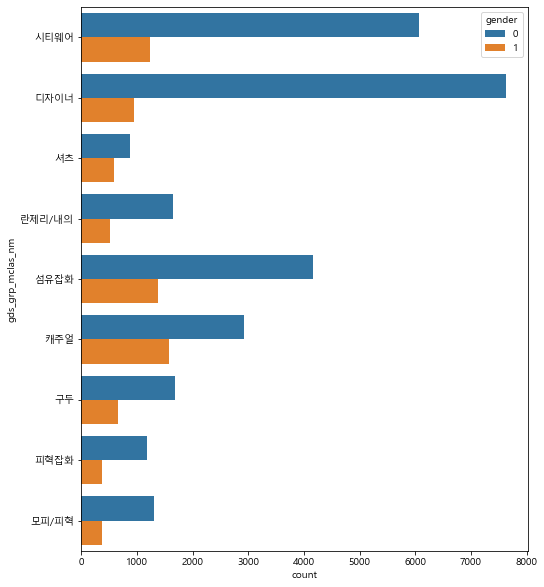

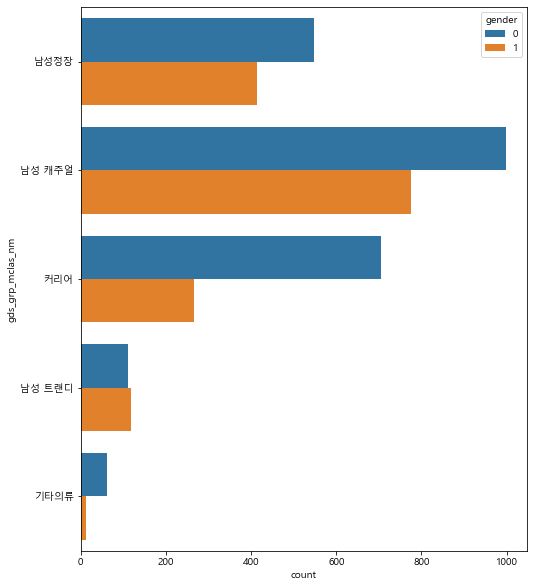

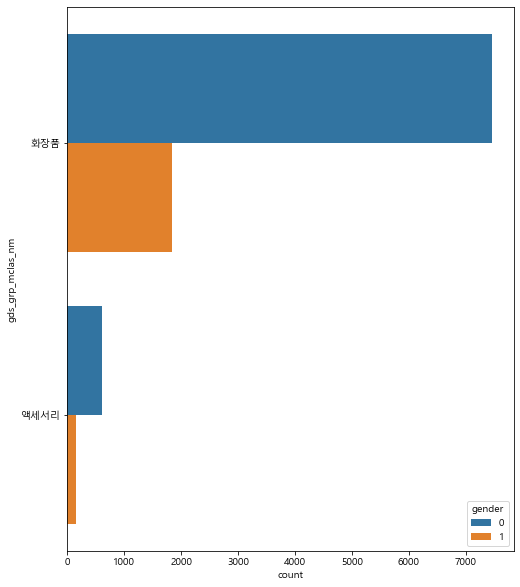

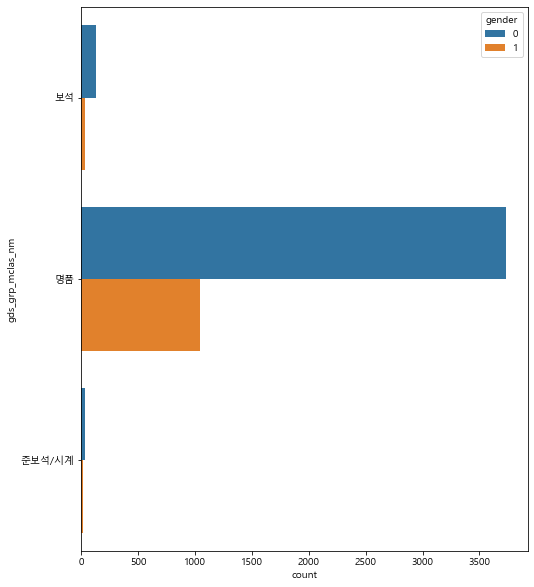

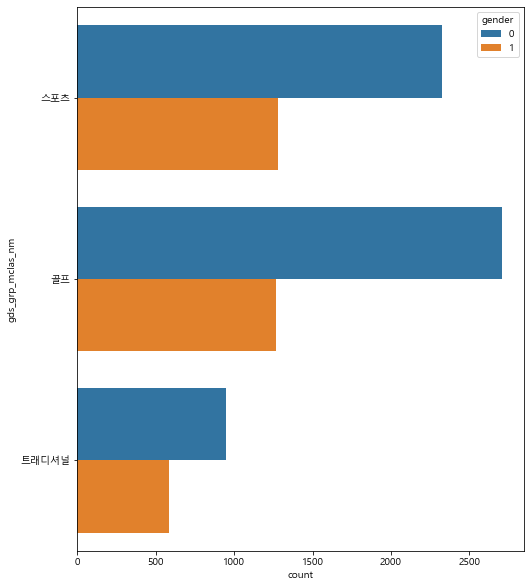

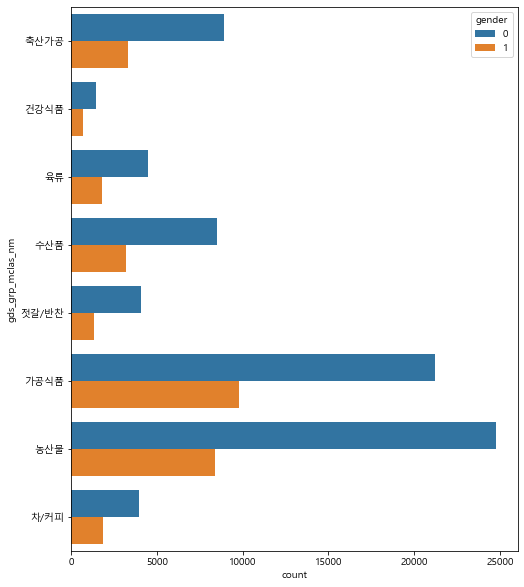

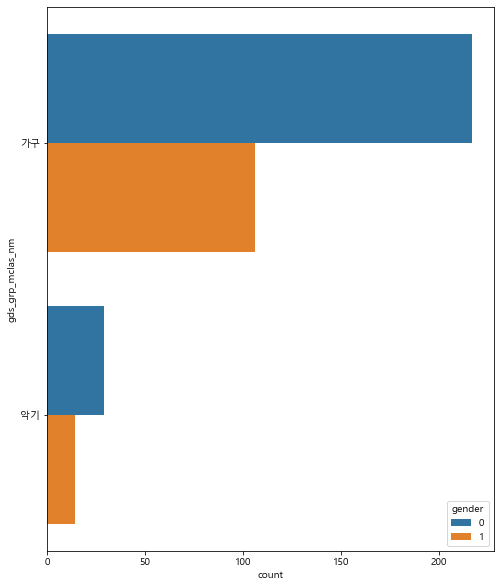

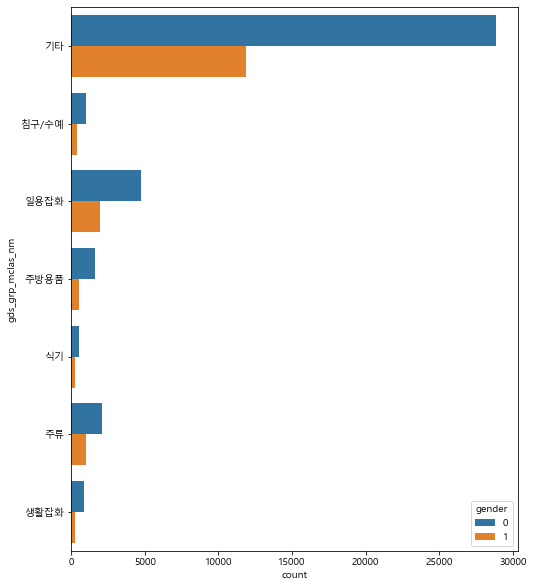

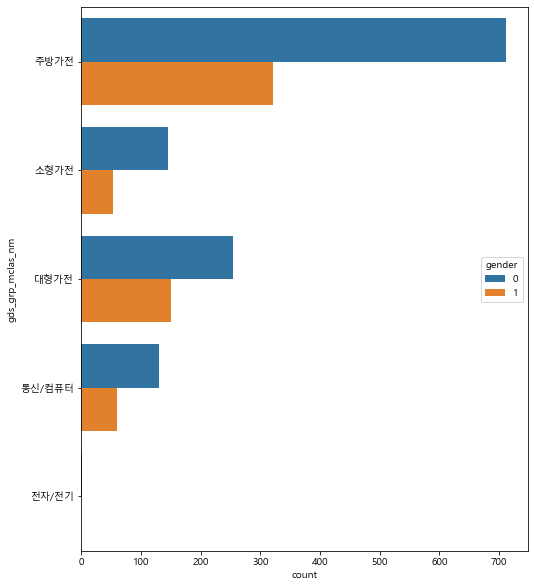

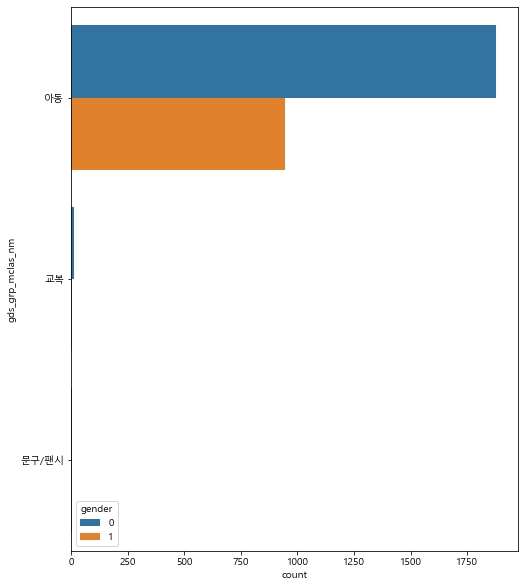

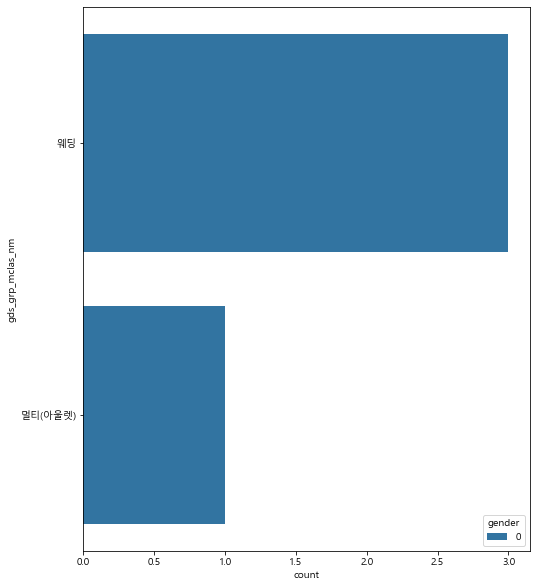

In [167]:
plt.rcParams['figure.figsize'] = [8, 10] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_mclas_nm', hue='gender'))
    plt.show()

### 2. countplot 으로 상품중분류명 grp_nm 살펴보기

 - 상품중분류명을 countplot으로 살펴본 결과 여성보다 남성이 구매수가 더 많은 상품들이 있다
     - 트랜디, 명품남성, 유아용품 이 이에 해당한다
 - 명품남성 같은 경우에는 남여 예측에 좋은 구분이 되겠지만, 다른 남성코너에서는 실제로 여성의 구매가 더 많았으므로 이는 남녀를 구분하기에 아직 정보가 부족하다고 생각되어서 상품소분류명까지 보기로 하였다

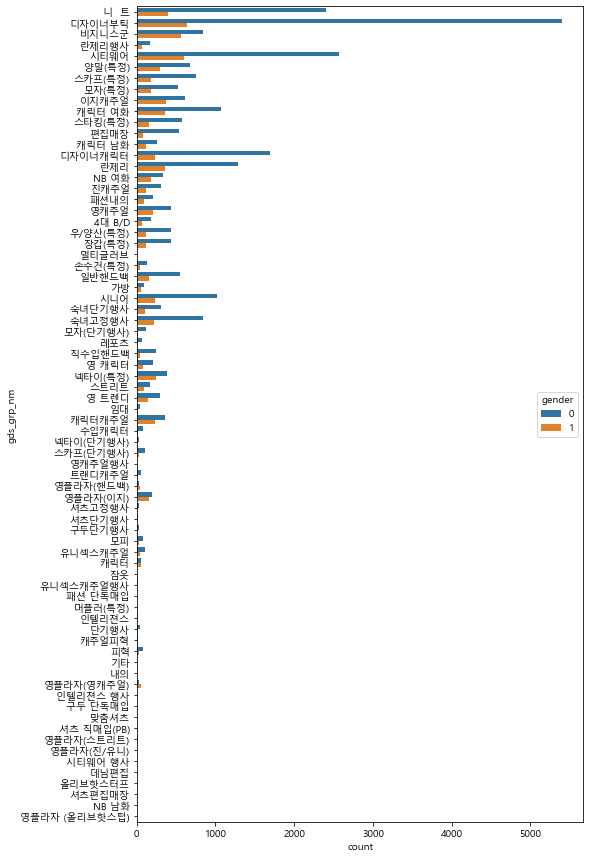

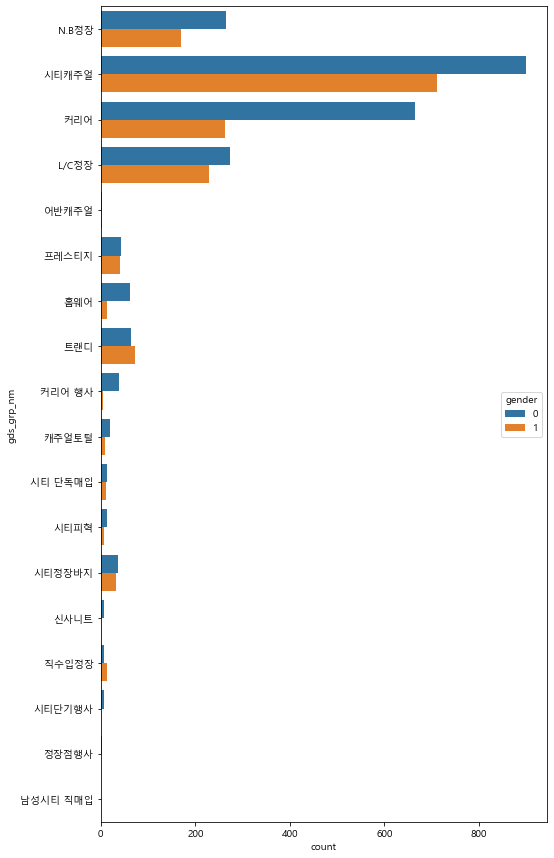

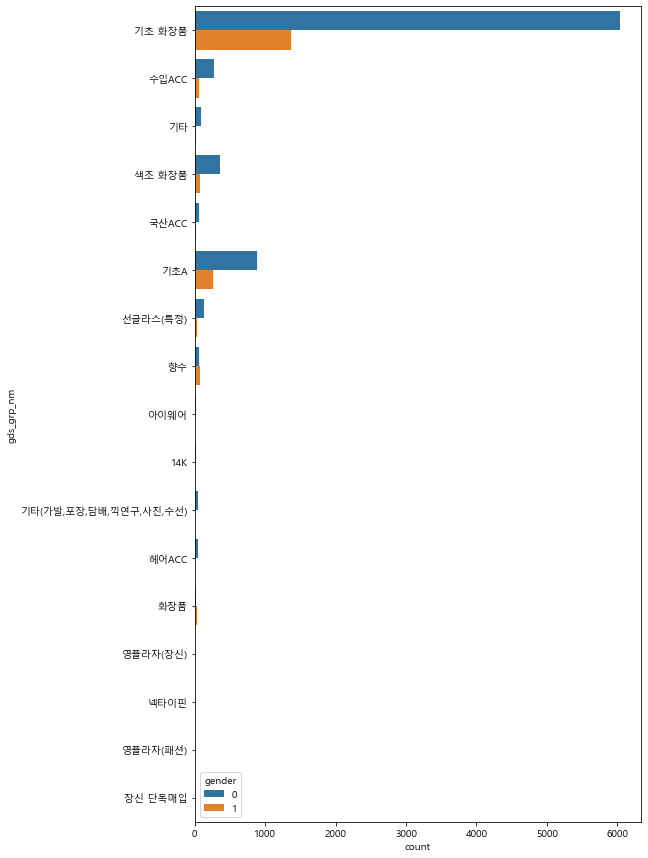

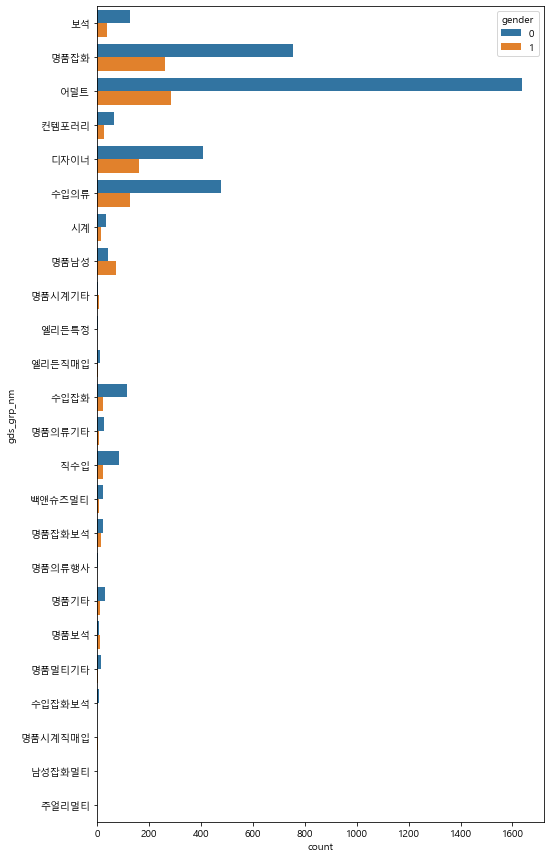

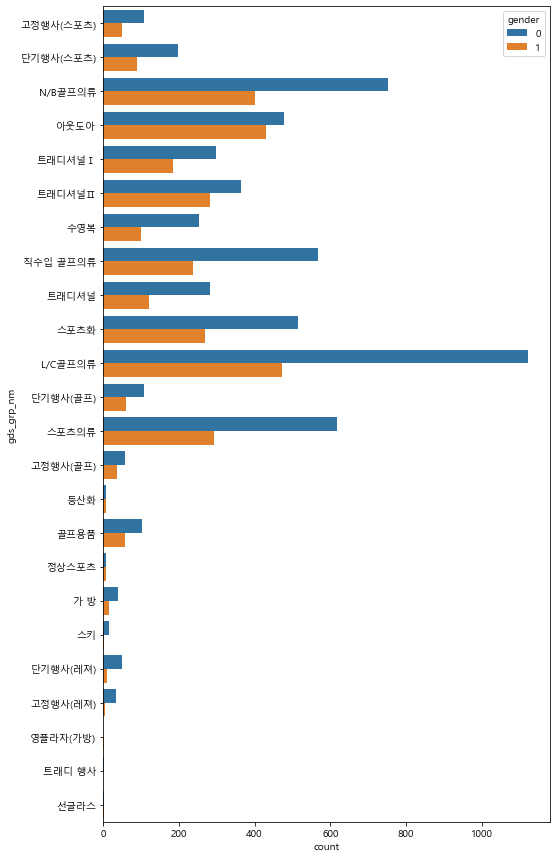

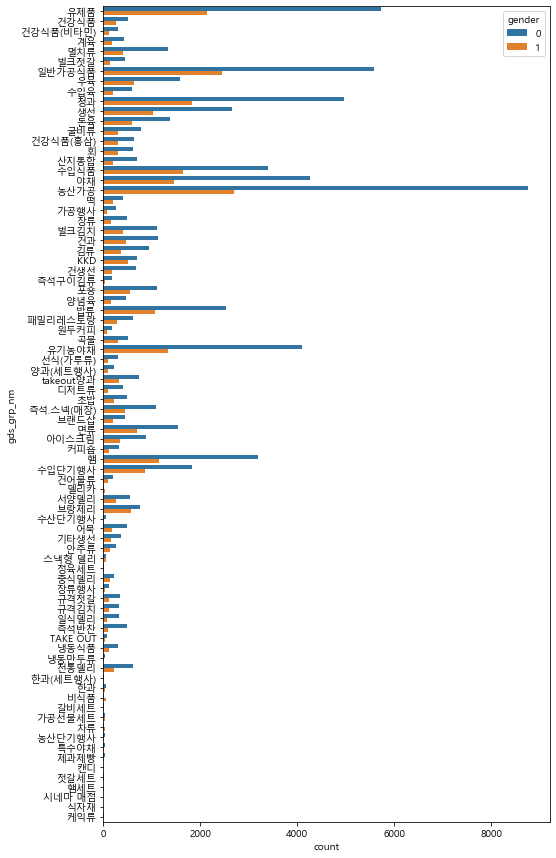

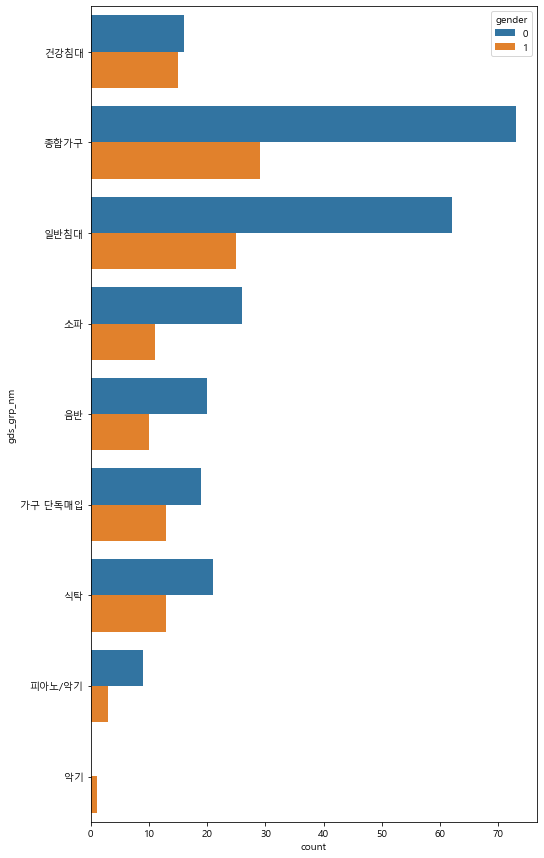

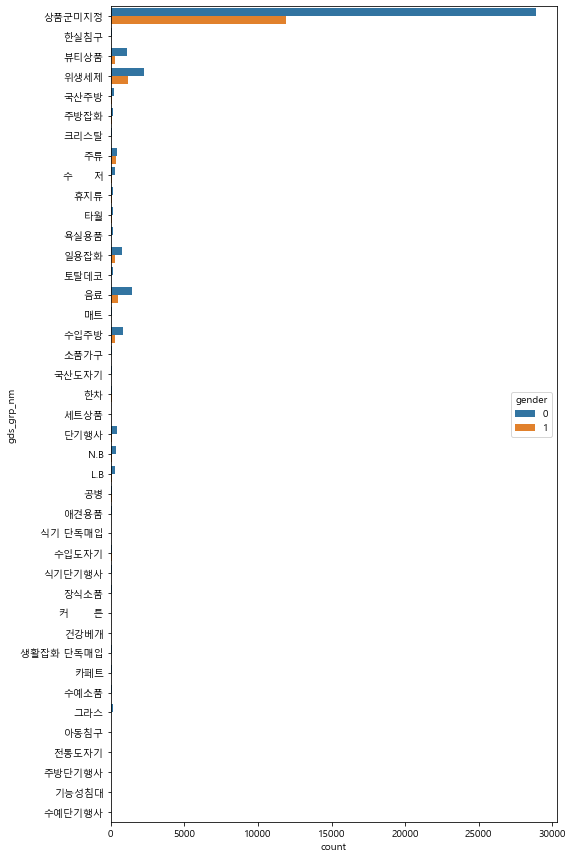

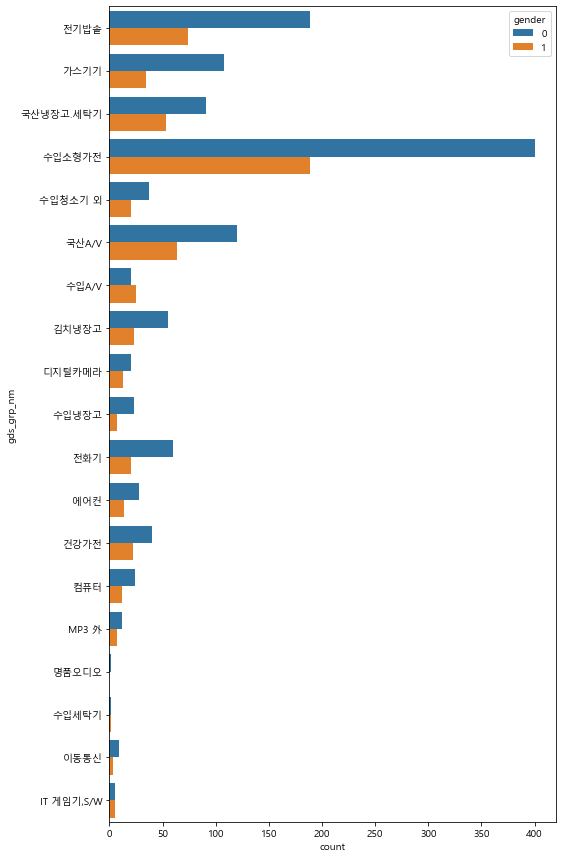

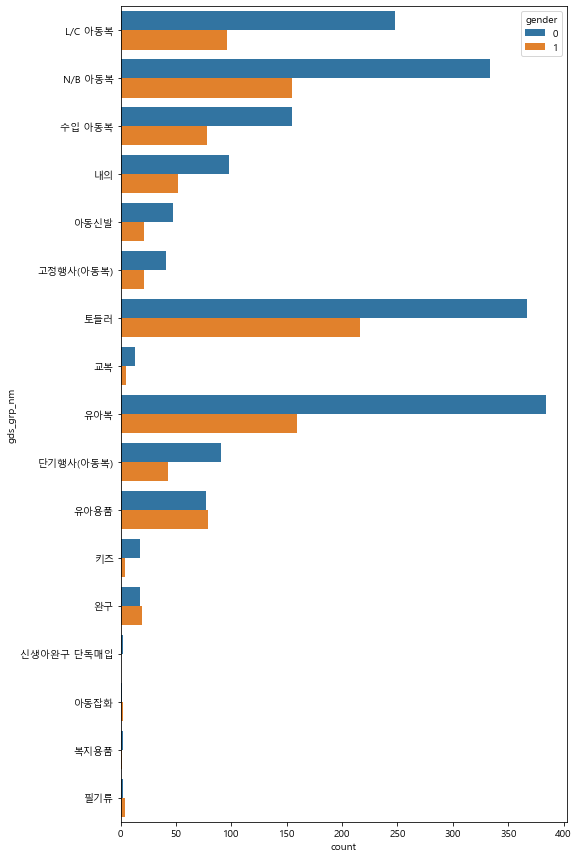

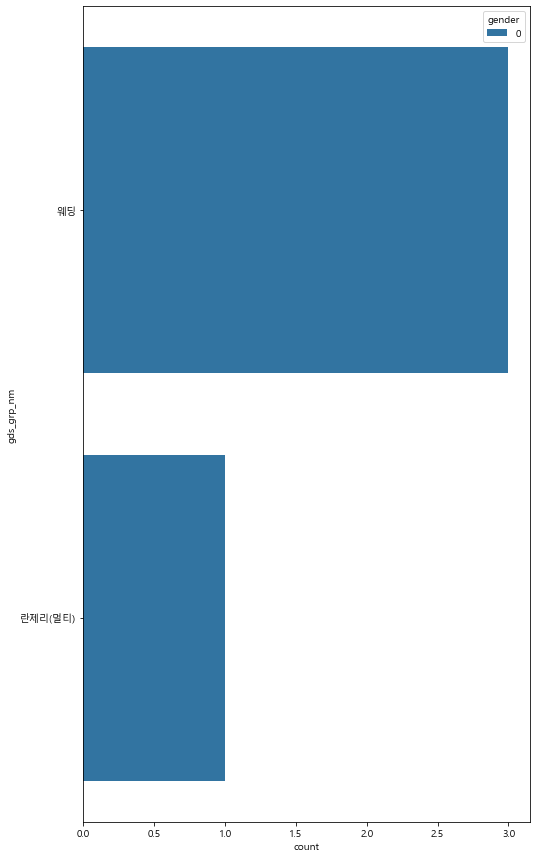

In [168]:
plt.rcParams['figure.figsize'] = [8, 15] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='gds_grp_nm', hue='gender'))
    plt.show()

### 3. countplot 으로 상품소분류명 살펴보기

 - 물품이 너무 많아 잘 보이지는 않지만 남성 전용의 물품인지 남성경향의 물품인지 확실히 남성들이 더 많이 구매하는 물품들이 보인다
 - 이에 그러한 goods_id 물품들을 모두 뽑아내기로 하였다

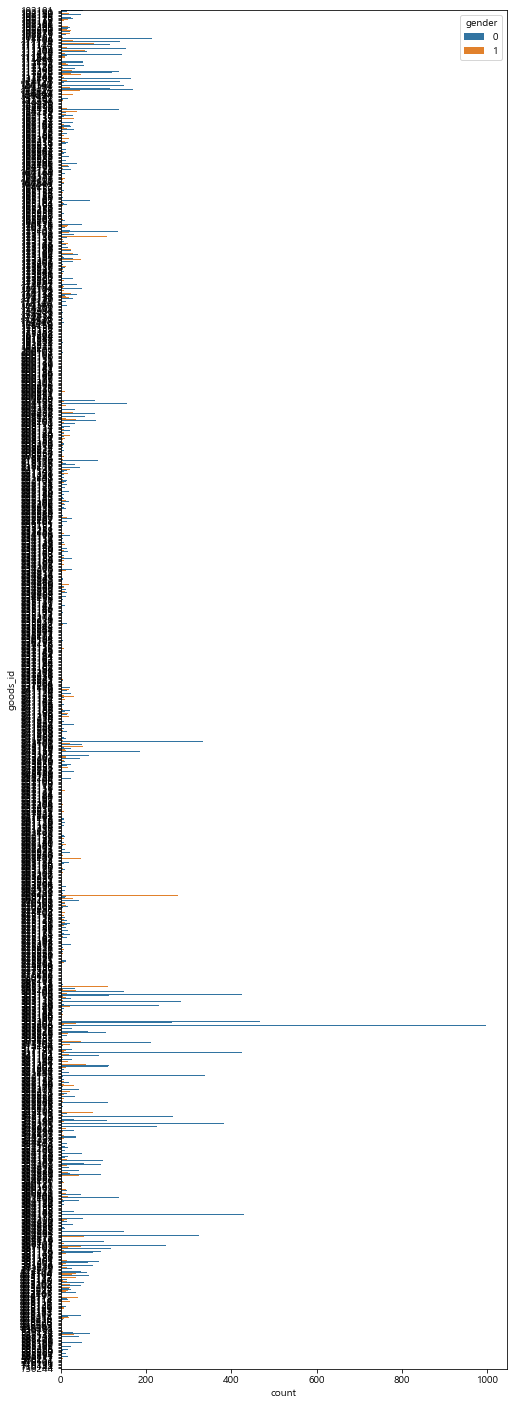

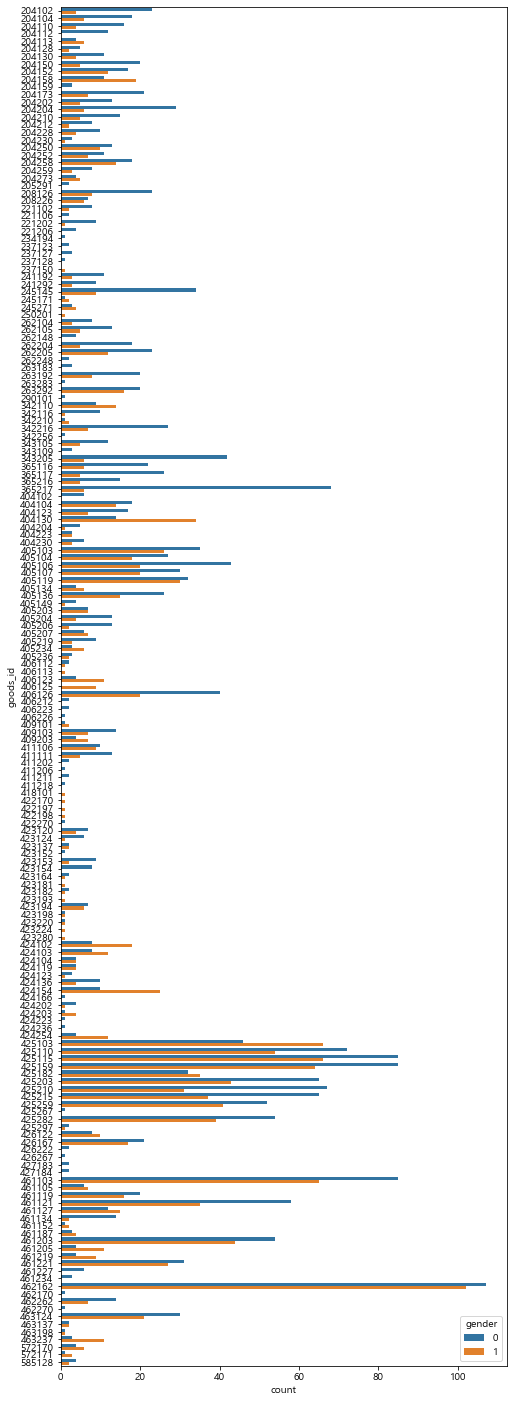

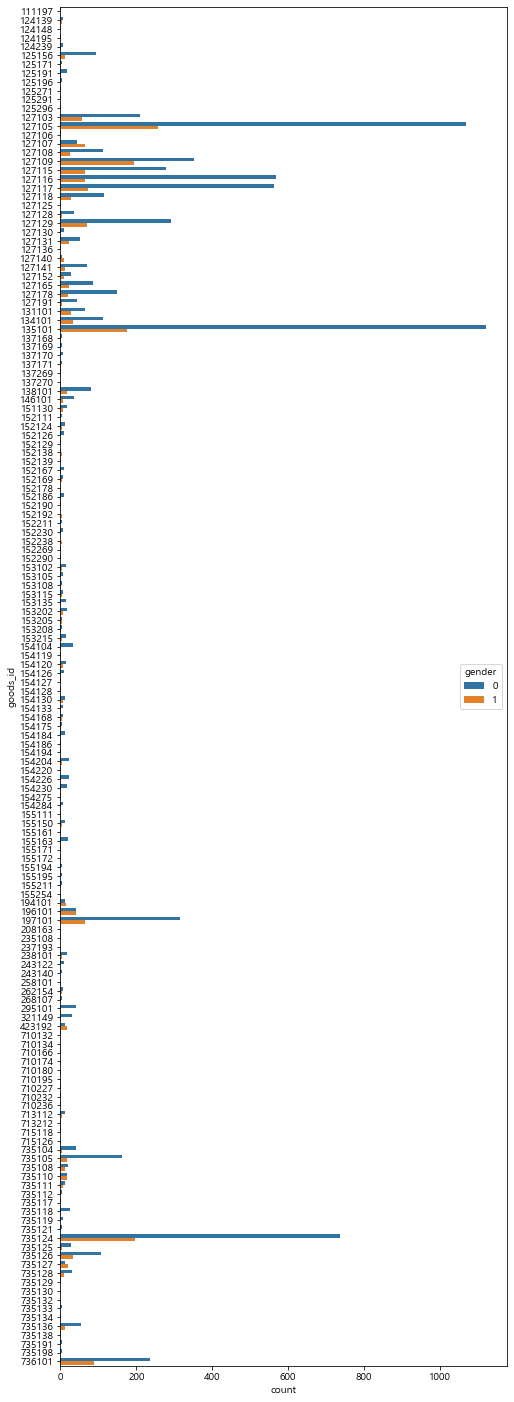

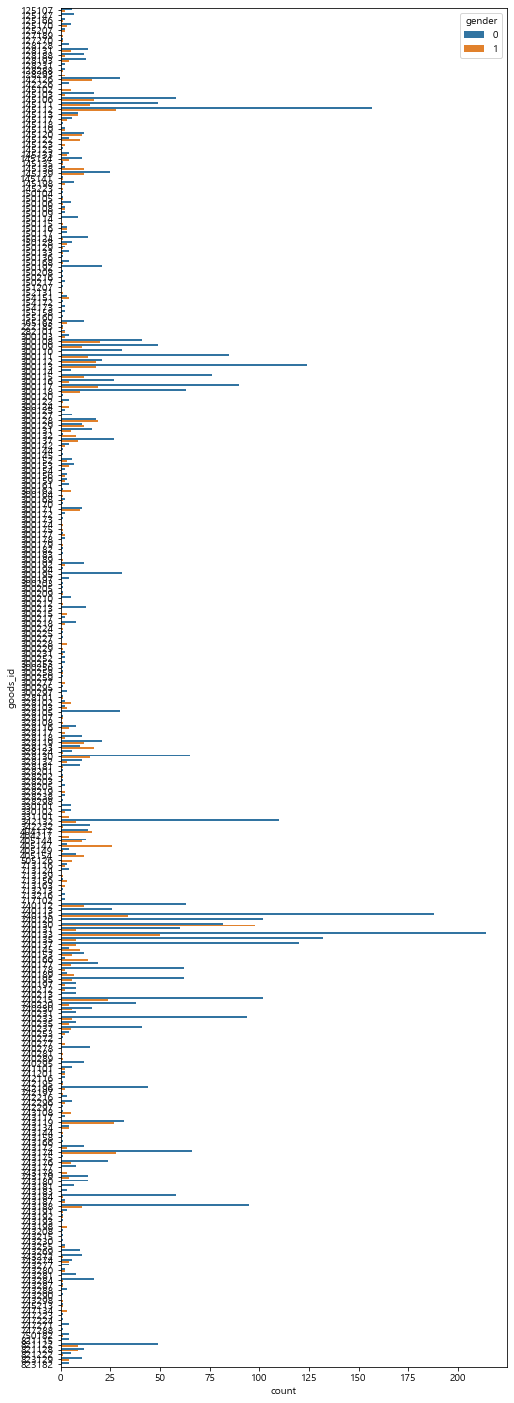

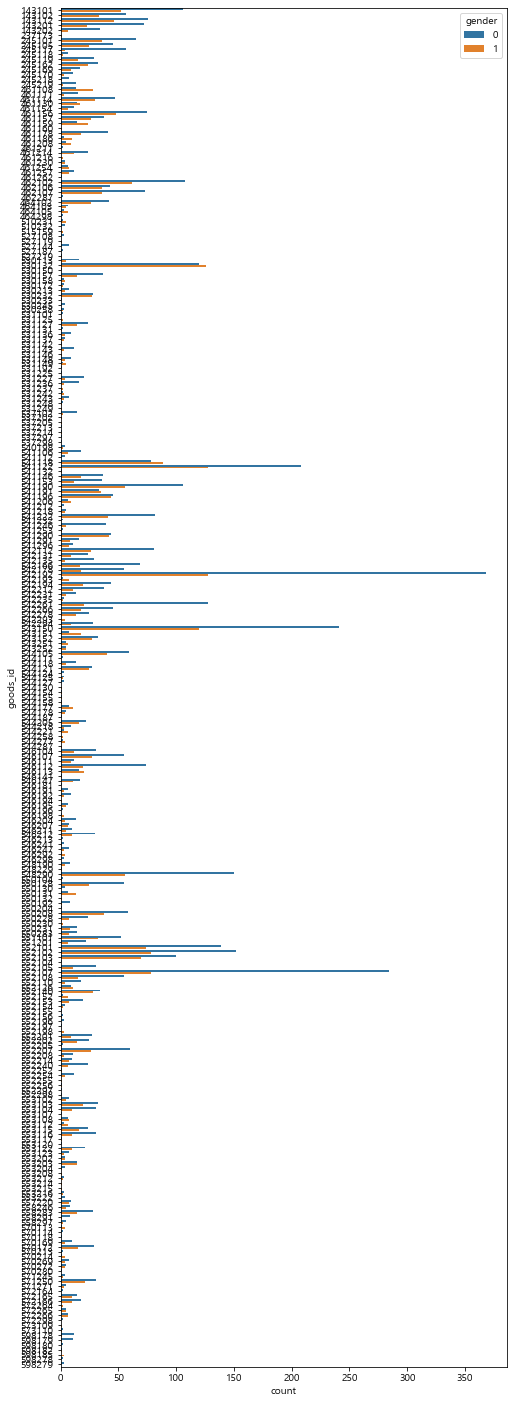

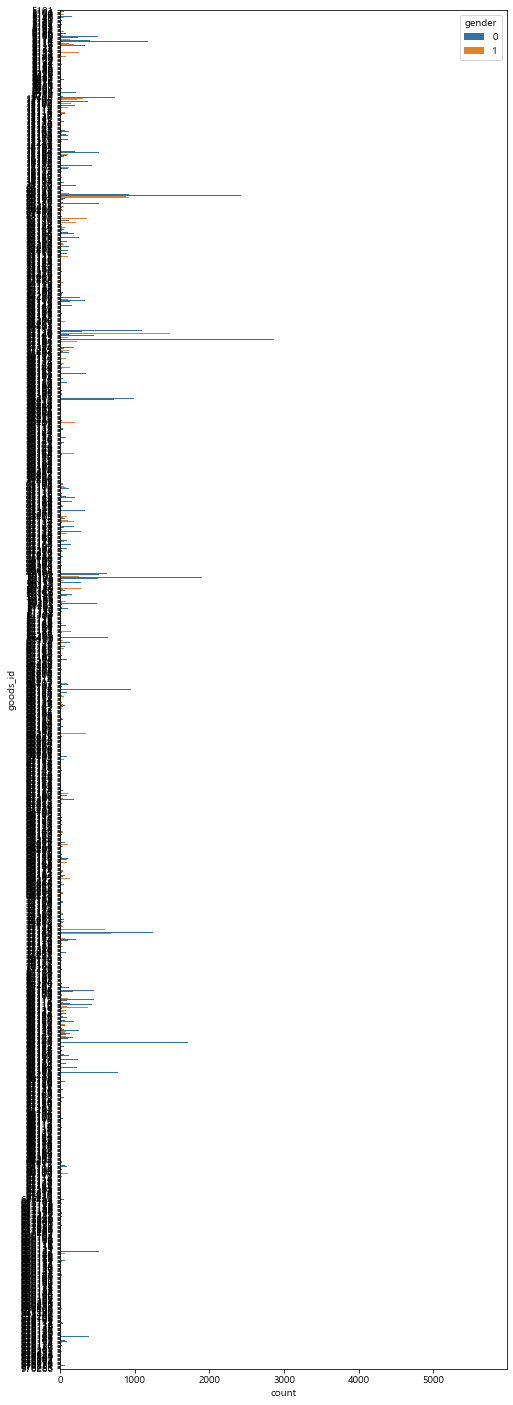

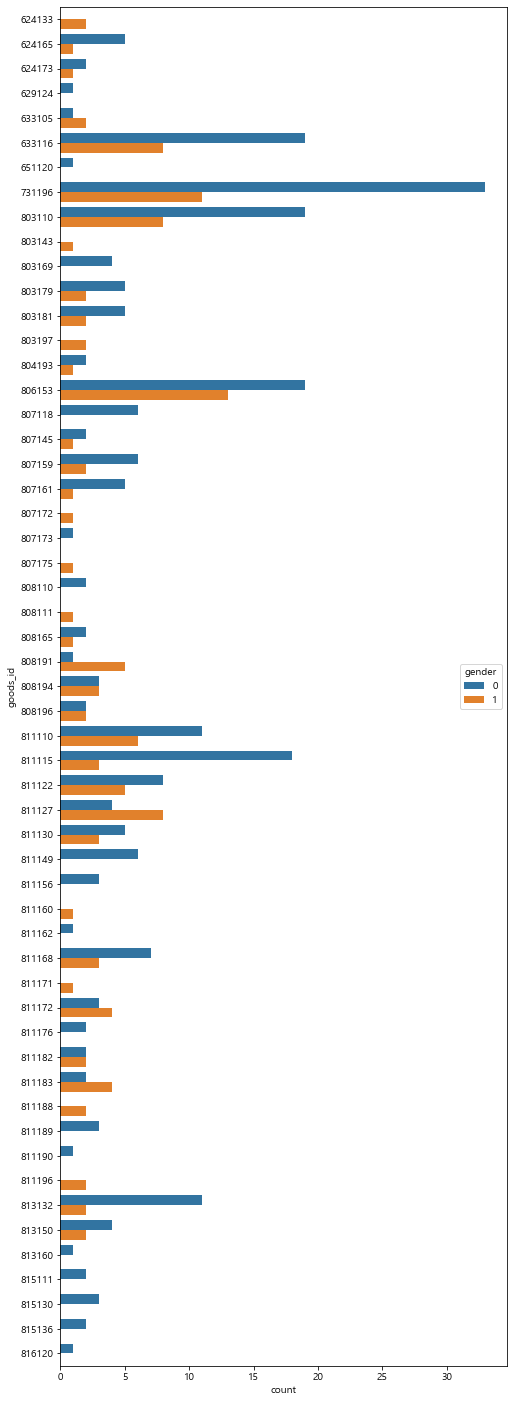

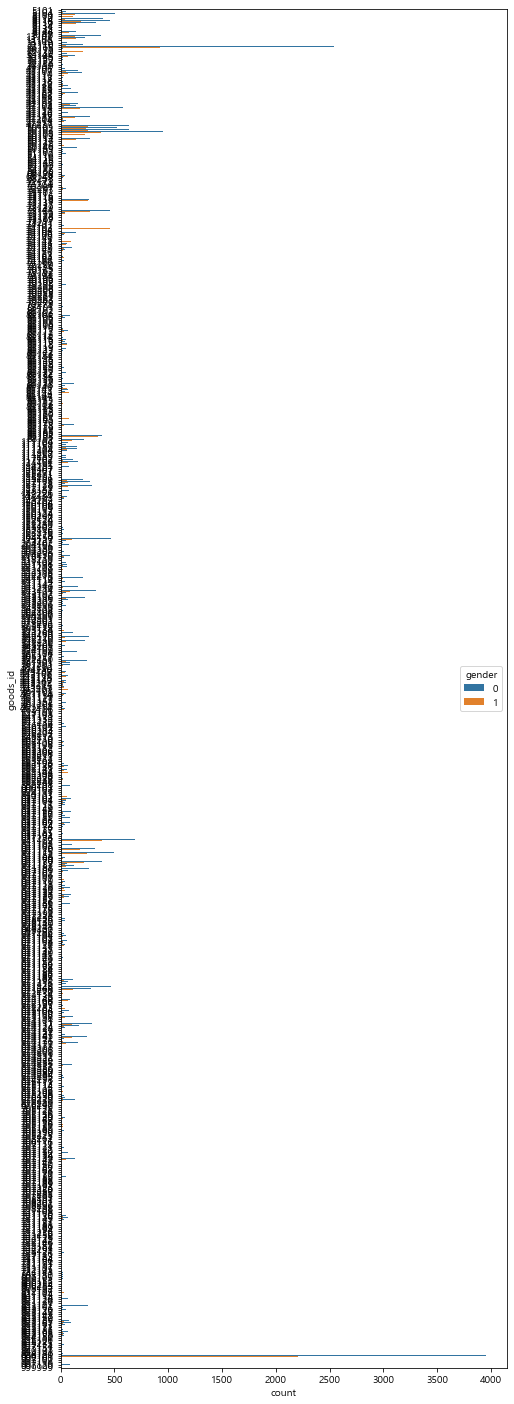

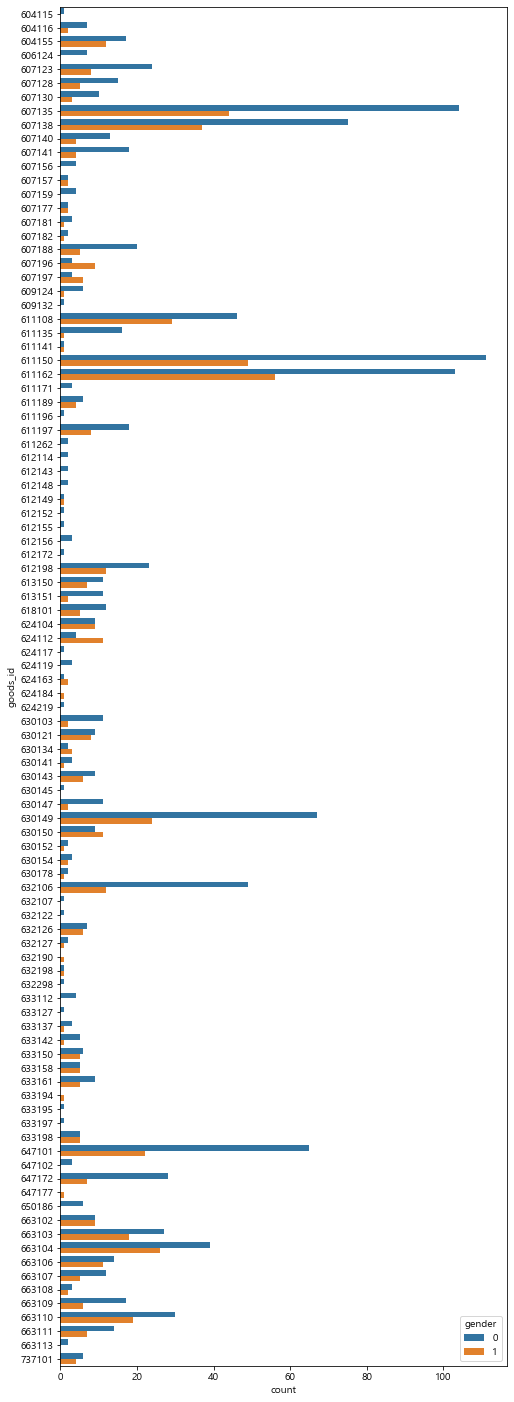

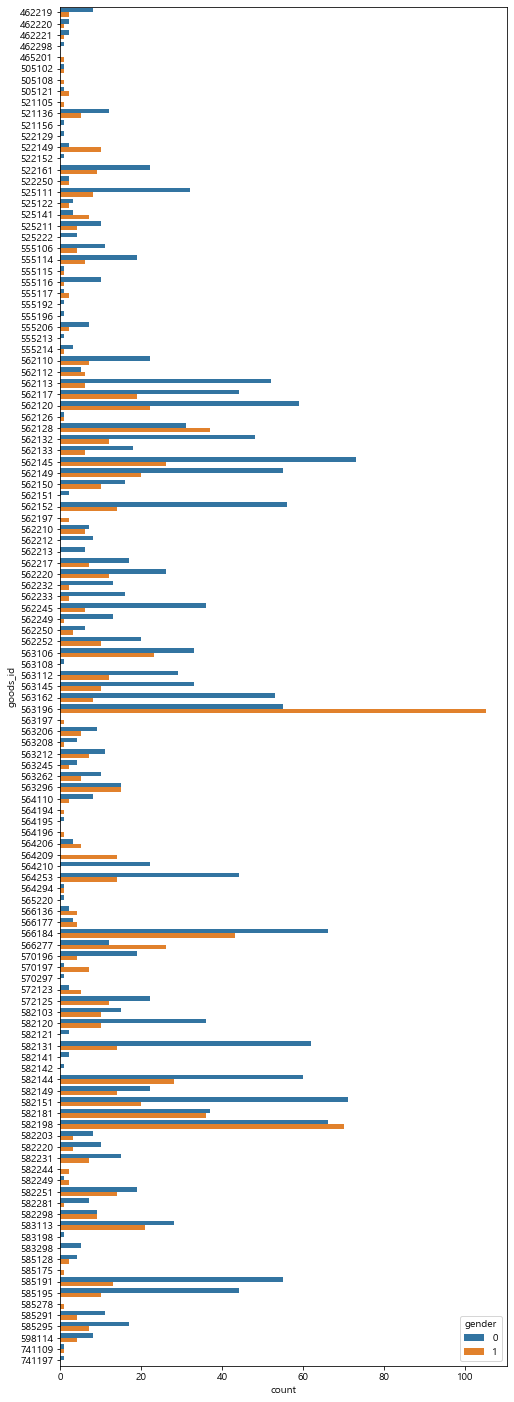

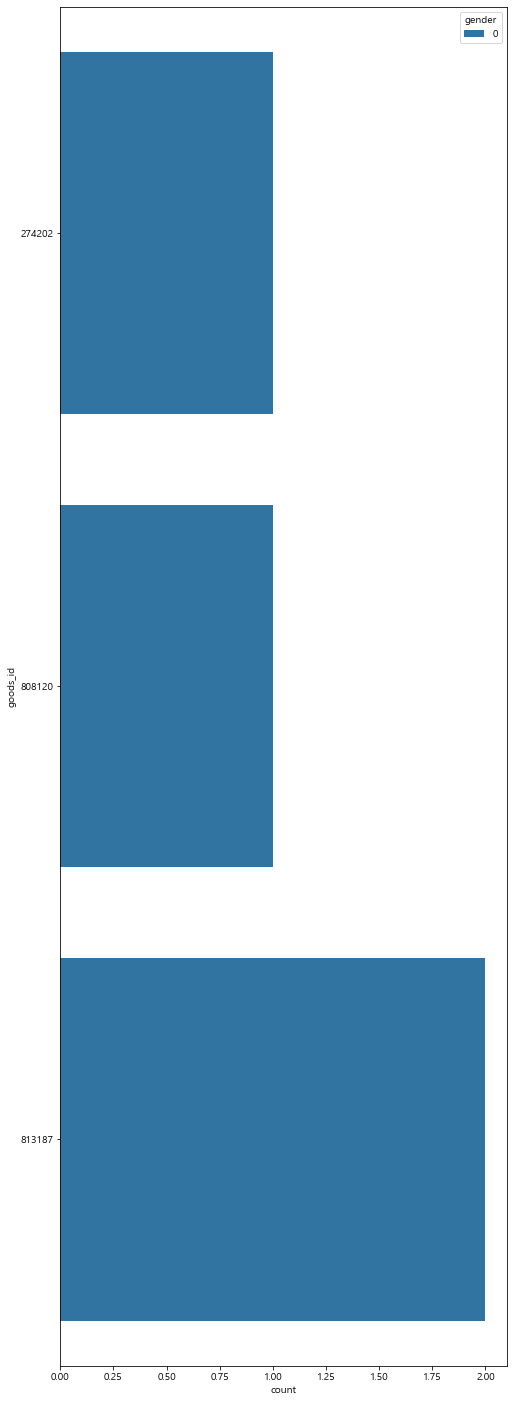

In [169]:
plt.rcParams['figure.figsize'] = [8, 25] # [width, height] (inches)
for mclas in all_mclas:
    
    display(sns.countplot(data=tr.query(f'gds_grp_mclas_nm in {mclas}'), y='goods_id', hue='gender'))
    plt.show()

### 4. goods_id에서 남성이 여성보다 더 많이 구매한 물품목록 뽑아내기

   - 남성이 여성보다 구매를 더 많이하면서, 남성이 3회이상 구매한 물품목록을 뽑아내었다
        - 위 조건에 해당하는 goods_id는 313개의 물품이 나왔다

In [170]:
temp_goodsdf = pd.pivot_table(tr, index = 'goods_id', columns='gender', values='amount', aggfunc=np.size, fill_value=0)

temp_goodsdf = temp_goodsdf.rename(columns={0:'women',1:'men'})

temp_goodsdf.query('men > women and men > 2')[:15]

gender,women,men
goods_id,,
5130,26,52
6163,2,3
6188,0,8
8134,4,8
8144,6,12
8190,13,36
8290,0,3
13109,0,20
13114,7,12


In [171]:
# 남성이 더 구매경향을 보이는 goods_id 상품들을 리스트로 뽑아내었다

men_tendency_product = temp_goodsdf.query('men > women and men > 2').index.tolist()

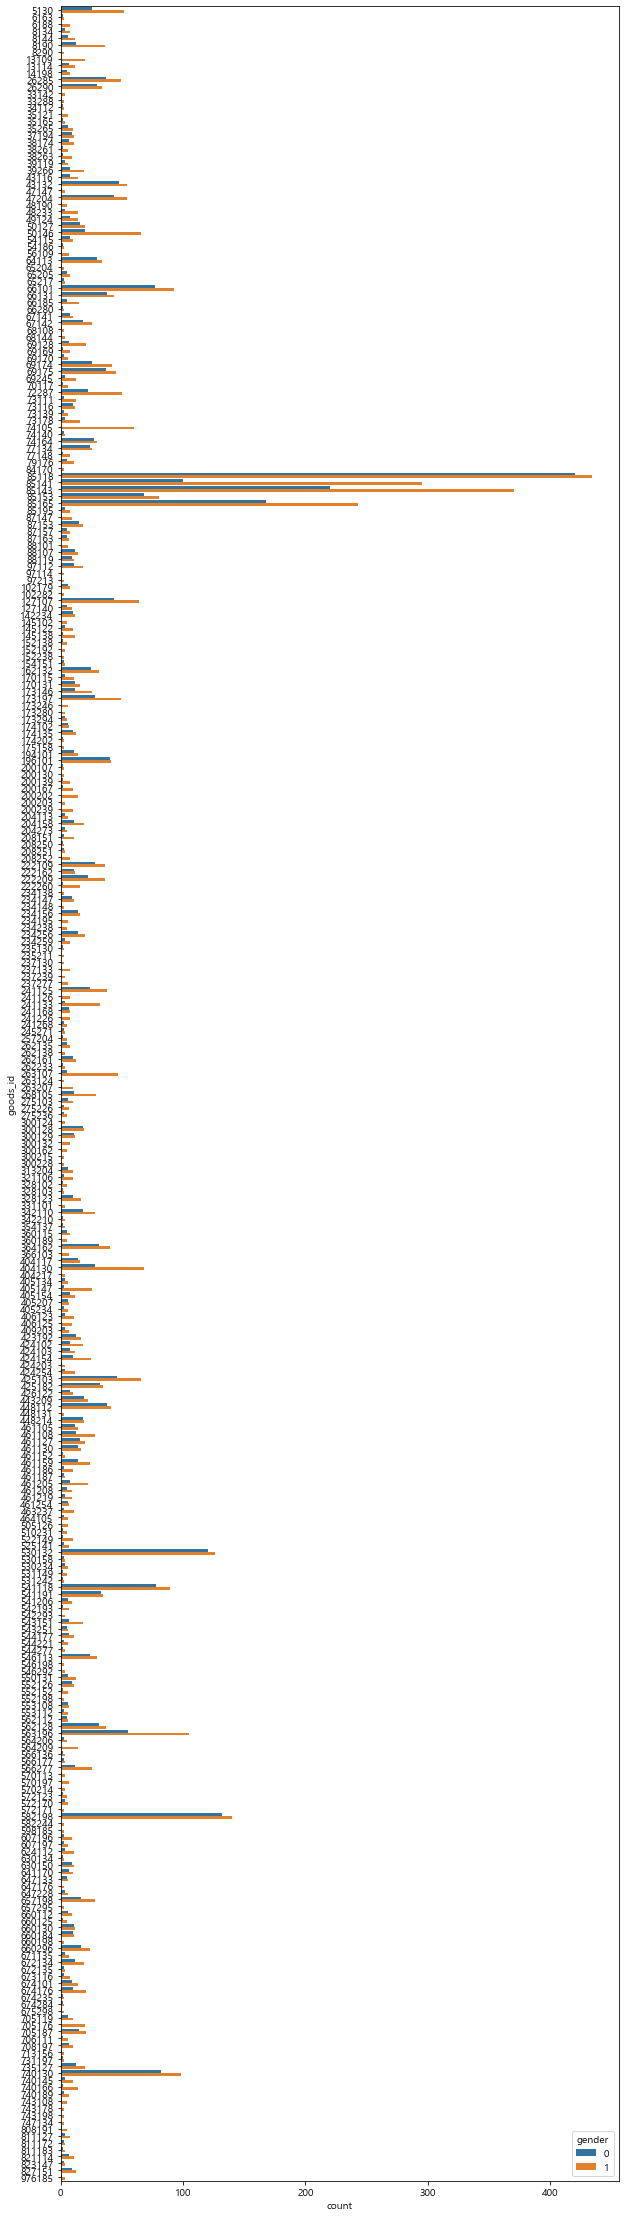

In [172]:
plt.rcParams['figure.figsize'] = [10, 40] # [width, height] (inches)
sns.countplot(data=tr.query('goods_id in @men_tendency_product'), y='goods_id', hue='gender')
plt.show()

### 5. 뽑아낸 물품목록으로 피쳐 생성하기

    - 0. tr2에서도 이에 해당하는 물품들을 뽑아내고 교집합물품들을 뽑아낸다 -> men_tendency_intersection
    - 1. men_tendency_product에 해당하는 goods_id를 구매하였는지 구매여부
    - 2. men_tendency_product의 구매건수

0. tr2에서도 조건에 해당하는 물품을 뽑아서 교집합하기

In [173]:
men_tendency_product2 = []

for goods_id in men_tendency_product:
    
    if goods_id in tr2.goods_id.unique():
        
        men_tendency_product2.append(goods_id)

In [174]:
# 교집합 품목을 뽑아낸다.
men_tendency_intersection = list(set(men_tendency_product).intersection(men_tendency_product2))

print('교집합 갯수: ', len(men_tendency_intersection))

교집합 갯수:  278


1. 구매여부 -> 구매하였을 경우 10을 주었다

In [176]:
for i in trs:

    temp_goodsdf = pd.pivot_table(i.query('goods_id in @men_tendency_intersection'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 모든 원소에 대해서 만약 원소가 0보다 크다면 10을 주었다 -> (구매안함: 0, 구매함: 10)
    temp_goodsdf = temp_goodsdf = temp_goodsdf.applymap(lambda x : 10 if x>0 else 0)

# 칼럼명 변경(겹치지 않도록)
    origin_name = temp_goodsdf.columns.tolist()
    new_name = [str(i)+'_M_tenden_isbuy' for i in origin_name]
    temp_goodsdf = temp_goodsdf.rename(columns=dict(zip(origin_name, new_name)))
    
    temp_goodsdf = temp_goodsdf.reset_index()

# nan값 제거    
    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500, 5982)]})
    f = pd.merge(merge_temp, temp_goodsdf, how='outer').fillna(0).astype(int)

In [177]:
f.iloc[:,1:].sum(axis=0)[:20]

5130_M_tenden_isbuy     120
6163_M_tenden_isbuy      10
6188_M_tenden_isbuy      10
8134_M_tenden_isbuy      30
8144_M_tenden_isbuy      20
8290_M_tenden_isbuy      20
13109_M_tenden_isbuy     10
13114_M_tenden_isbuy    100
14198_M_tenden_isbuy     90
26285_M_tenden_isbuy    120
26290_M_tenden_isbuy    100
33288_M_tenden_isbuy     10
34112_M_tenden_isbuy     30
35165_M_tenden_isbuy     10
35265_M_tenden_isbuy     80
37194_M_tenden_isbuy     10
38261_M_tenden_isbuy     30
38263_M_tenden_isbuy     30
39266_M_tenden_isbuy    130
43116_M_tenden_isbuy     60
dtype: int64

## ch.2

### 1. 남성만 혹은 여성만 구매하는 제품을 조사

   - 남성들만 혹은 여성들만 구매한 제품군들이 있음을 확인
        - 데이터 불균형을 해소하고자 남성을 구분할 수 있도록 남성들만 쓰는 제품들을 살펴보았으나 goods_id까지 봤지만 데이터가 600여개로 너무 적었음
        - 이에 차라리 데이터가 많은 여성측에서 여성경향이 강한 제품들로 여성을 구분하고자 함

In [178]:
print("---- 전체 ----")

print('대분류: ', tr.gds_grp_mclas_nm.nunique())

print('중분류: ', tr.gds_grp_nm.nunique())

print('소분류: ', tr.goods_id.nunique())

print('\n\n---- 남성 ----')

print('대분류: ', tr.query('gender == 1').gds_grp_mclas_nm.nunique())

print('중분류: ', tr.query('gender == 1').gds_grp_nm.nunique())

print('소분류: ', tr.query('gender == 1').goods_id.nunique())

print('\n\n---- 여성 ----')

print('대분류: ', tr.query('gender == 0').gds_grp_mclas_nm.nunique())

print('중분류: ',tr.query('gender == 0').gds_grp_nm.nunique())

print('소분류: ',tr.query('gender == 0').goods_id.nunique())

---- 전체 ----
대분류:  49
중분류:  324
소분류:  3471


---- 남성 ----
대분류:  46
중분류:  308
소분류:  2618


---- 여성 ----
대분류:  49
중분류:  315
소분류:  3200


## 2. 여성만 쓰는 제품목록 뽑아내기

 - 여성들만 구매하는 제품목록을 대분류 -> 중분류 -> 소분류 순으로 살펴본 결과 대분류, 중분류만으로는 데이터가 너무 적어 구분하기 어렵다고 판단
 - 여성들만 구매하는 소분류(goods_id)제품들을 리스트로 뽑아내었음
     - 조건1: 여성들만 구매
     - 조건2: 여성들이 적어도 3회 이상 구매
     - 조건3: 여성들이 적어도 3명 이상 구매
 - 조건을 모두 만족시키는 제품군을 뽑아서 여성을 구분하는 피쳐를 만들고자 함

조건1

In [179]:
w_use_goods = tr.query('gender == 0').goods_id.unique().tolist()

m_use_goods = tr.query('gender == 1').goods_id.unique().tolist()

all_use_goods = tr.goods_id.unique().tolist()

In [180]:
w_goods = []
for goods in all_use_goods:
     if goods not in m_use_goods:
            w_goods.append(goods)

print('\n여성의 수: ',tr.query('gender == 0').cust_id.nunique())
print('\n여성경향 물품을 구매한 여성 수: ', tr.query('goods_id in @w_goods')['cust_id'].nunique())
print(f'\n여성경향 물품을 구매한 여성 비율: {788 / 2184:.4}')

print('\n여성들만 쓰는 제품수: ', len(w_goods))


여성의 수:  2184

여성경향 물품을 구매한 여성 수:  788

여성경향 물품을 구매한 여성 비율: 0.3608

여성들만 쓰는 제품수:  853


조건2 와 조건3

In [181]:
w_buymorethan3df = tr.query('gender == 0').groupby('cust_id')['goods_id'].value_counts().rename().reset_index().rename(columns={0:'count'})

w_buymorethan3lst = w_buymorethan3df.query('count >= 3').goods_id.unique().tolist()

print('여성들이 3회이상 구매한 물품 목록 수: ', len(w_buymorethan3lst))

w_goodsdf = tr.query('gender == 0').goods_id.value_counts().reset_index().query('goods_id>=3').rename(columns={'index':'goods_id','goods_id':'count'})

w_morethan3pplbuy = w_goodsdf.goods_id.unique().tolist()

print('\n여성들이 3명이상 구매한 물품 목록 수: ', len(w_morethan3pplbuy))

여성들이 3회이상 구매한 물품 목록 수:  1511

여성들이 3명이상 구매한 물품 목록 수:  2367


조건 1,2,3을 모두 만족하는 물품목록(여성만 구매, 여성이 3회이상 구매, 여성이 3명이상 구매)

In [182]:
# 조건1과 조건2 교집합
con1AndCon2 = set(w_goods).intersection(w_buymorethan3lst)

# 교집합된 목록과 조건3의 교집합
w_tendency_product = list(con1AndCon2.intersection(w_morethan3pplbuy))

print('교집합된 물품 목록 수: ', len(w_tendency_product))

교집합된 물품 목록 수:  155


##  3. 뽑아낸 물품목록으로 피쳐 생성하기

 - test데이터도 같은 과정을 거쳐 피쳐를 생성해야하나 gender가 없기 때문에 test데이터의 goods_id와 교집합
 - 둘다 만족하는 최종 w_tendency_product를 토대로 피쳐생성
     - 1. 여성경향 물품 구매건수
     - 2. 여성경향 물품 구매여부

In [183]:
# test데이터의 goods_id 목록
tr2_goodslst = tr2.goods_id.unique().tolist()

# test데이터에도 존재하는 여성경향 몰품 목록 찾기
final_w_tendency_product = []
for product in w_tendency_product:
    
    if product in tr2_goodslst:
        
        final_w_tendency_product.append(product)

# 최종 여성경향 물품목록 추출
print(final_w_tendency_product)
print()
print('개수: ', len(final_w_tendency_product))

[262148, 72204, 221206, 47127, 731171, 562212, 5160, 262189, 303153, 303158, 88120, 88123, 152126, 26179, 67148, 300110, 322128, 641106, 300114, 66136, 87132, 300127, 150114, 257124, 67173, 364135, 43126, 303225, 64124, 364158, 85119, 342143, 322176, 404102, 66186, 85131, 660108, 660106, 85134, 175257, 300195, 85155, 342181, 85160, 300213, 85181, 173245, 303295, 233152, 85187, 807118, 275156, 321247, 84192, 637155, 235243, 423154, 550130, 976118, 43267, 38151, 743177, 191242, 743180, 743181, 740113, 234262, 740120, 274202, 84279, 34106, 16195, 204112, 35152, 674137, 54106, 54110, 38245, 33126, 743281, 354167, 823159, 77178, 821115, 33150, 352130, 54146, 821126, 976263, 740231, 32138, 248198, 165260, 73102, 38287, 676240, 164252, 74147, 546213, 671146, 79273, 461227, 33198, 35247, 671152, 243122, 461234, 740278, 243140, 8135, 740295, 222154, 650186, 35287, 564210, 8183, 8186]

개수:  117


이러한 물품을 구매한 여성의 비율

In [184]:
print('전체 여성 수:', tr.query('gender == 0').cust_id.nunique())

print('\n여성 경향 물품을 구매한 여성 수:', tr.query('goods_id in @final_w_tendency_product').cust_id.nunique())

print(f'\n여성 경향 물품을 구매한 여성의 비율: {350/2184:.4}')

전체 여성 수: 2184

여성 경향 물품을 구매한 여성 수: 350

여성 경향 물품을 구매한 여성의 비율: 0.1603


2. 여성경향 물품 구매여부

In [185]:
for i in trs:

    w_tempdf = pd.pivot_table(i.query('goods_id in @final_w_tendency_product'), index='cust_id', columns='goods_id', values='amount', aggfunc=np.size, fill_value=0)

# 구매여부 조건: 샀을경우 20 아니면 0
    w_tempdf = w_tempdf.applymap(lambda x: 20 if x > 0 else 0)

    origin = w_tempdf.columns.tolist()
    new_name = [str(i)+'_w_ten_isbuy' for i in range(len(origin))]
    w_tempdf = w_tempdf.rename(columns=dict(zip(origin, new_name)))

    if len(i) == 232004:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500)]})
    else:
        merge_temp = pd.DataFrame({'cust_id':[i for i in range(3500,5982)]})

    w_tempdf = w_tempdf.reset_index()

    f = pd.merge(merge_temp, w_tempdf, how='outer').fillna(0)

### Merge & Save Features


In [ ]:
for i in features:
    if len(i) == 3500:
        features1.append(i)
    else:
        features2.append(i)
print(len(features1))
print(len(features2))

both_features = [features1, features2]

In [ ]:
data = pd.DataFrame({'cust_id': tr.cust_id.unique()})
for f in features1 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_train_after_eda.csv', index=False, encoding='cp949')
data.info()

In [ ]:
data = pd.DataFrame({'cust_id': tr2.cust_id.unique()})
for f in features2 :
    data = pd.merge(data, f, how='left')
display(data)
data.to_csv('X_test_after_eda.csv', index=False, encoding='cp949')
data.info()

## ────────────────────────────────────────────────────────

###  피쳐 상관관계

#### 1차 피쳐 상관관계

<font color = 'blue'> EDA 이후 채택되지 않은 피쳐들 제거

가격: 가격 선호도, 환불금액, 환불건수, 내점 당 구매액,      
시간: 월별 방문비율, 월별 구매건수, 월초, 월중, 월말 선호 방문때, 최근 3개월, 6개월, 12개월 구매금&구매건수   
장소: 주구매지점   
제품: Top-10 베스트 셀러(gds_grp_mclas_nm)에 대한 구매 금액/건수/여부(겹쳐서)   
기타: 휴면(또는 이탈)여부 

<font color = 'blue'> 같은 관점의 피쳐끼리 상관관계
    - 같은 관점끼리 히트맵을 그려 상관관계가 0.7이상인 칼럼들을 모두 제거하였다
    - 밑의 히트맵은 상관관계가 높았던 칼럼들의 제거 이후에 그린 히트맵이다

상관관계가 0.7이상으로 높아서 삭제한 칼럼들   


가격: none   
시간: 월초, 월중, 월말 구매건수&구매비율, 요일별 구매건수, 주말 구매건수, 1월 구매비율, 수목금 구매비율   
장소: top12 방문비율   
제품: 소중대분류에서 상관관계 높은 상품 162개   
기타: none


In [ ]:
df = pd.read_csv('X_train_after_eda.csv', encoding='cp949')
X_test = pd.read_csv('X_test_after_eda.csv', encoding='cp949')

In [ ]:
high_corr_cols = []

delCol1 = ['0to10_10unit', '11to20_20unit', '21to31_30unit','4_buy', '3_buy', '2_buy','0_buy','6_buy','5_buy','1_buy','weekend_buy2', '1_month_amount','2_month_amount','0to10_amount','0to10_amount','11to20_20unit','21to31_amount','3_amount','2_amount','4_amount']

delCol2 = ['0_visits0','1_visits1','2_visits2','3_visits3','4_visits4','5_visits5','6_visits6','7_visits7','8_visits8','9_visits9','10_visits10']

delCol3 = ['num_pur_type2', 'num_pur_type3']

delCol4 = ['241192', '262241', '263107', '542166', '740195', '742196', '241125_buy', '241133_buy', '241192_buy', '262141_buy', '262241_buy', '263107_buy', '342111_buy', '342132_buy', '562128_buy', '563196_buy', '740195_buy', '742196_buy', '96grp_nm_buy', '141grp_nm_buy', '165grp_nm_buy', '189grp_nm_buy', '195grp_nm_buy', '18mclas_nm_buy', '48mclas_nm_buy', '63mclas_nm_buy', '56108', '607138', '811110', '66123_buy', '77152_buy', '303126_buy', '321103_buy', '542192_buy', '607138_buy', '39grp_nm', '45grp_nm', '192grp_nm', '12grp_nm_buy', '15grp_nm_buy', '36grp_nm_buy', '45grp_nm_buy', '111grp_nm_buy', '3mclas_nm', '15mclas_nm', '15mclas_nm_buy', '21mclas_nm_buy', '45mclas_nm_buy', '26165', '66123', '68273', '73119', '125156', '127118', '127128', '127131', '127141', '128128', '128131', '173197', '204125', '204128', '204152', '204162', '206101', '208102', '208110', '208121', '208140', '222102', '245105', '245117', '245140', '261188', '275131','303125', '303140', '321106', '322103', '322154', '322158', '331101', '342150', '361106', '361206', '365219', '530157', '530232', '541153', '542266', '552110', '562117', '562132', '563112', '611150', '611162', '611189', '613151', '624165', '630134', '647101','663102', '663106', '663108', '663110', '663111', '735105', '735124', '737101', '740112', '740120', '740130', '740131', '740153', '740177', '740178', '740215', '808194', '811115', '811127', '811156', '813150', '823165', '37140_buy', '56108_buy', '73151_buy', '127109_buy', '262161_buy', '303109_buy', '303110_buy', '303146_buy', '303209_buy', '303246_buy', '322111_buy', '322211_buy', '562113_buy', '611150_buy', '618101_buy', '647101_buy', '663106_buy', '731196_buy', '735124_buy', '9grp_nm', '42grp_nm', '54grp_nm', '72grp_nm', '78grp_nm', '93grp_nm', '135grp_nm', '198grp_nm', '42grp_nm_buy', '54grp_nm_buy', '72grp_nm_buy', '78grp_nm_buy', '93grp_nm_buy', '108grp_nm_buy', '117grp_nm_buy', '135grp_nm_buy', '138grp_nm_buy', '171grp_nm_buy', '192grp_nm_buy', '198grp_nm_buy']

delCol5 = ['8134_M_tenden_isbuy', '13109_M_tenden_isbuy', '87147_M_tenden_isbuy', '200202_M_tenden_isbuy', '200239_M_tenden_isbuy', '263107_M_tenden_isbuy', '263207_M_tenden_isbuy', '300215_M_tenden_isbuy', '300228_M_tenden_isbuy', '598185_M_tenden_isbuy', '647176_M_tenden_isbuy', '705176_M_tenden_isbuy', '713156_M_tenden_isbuy']

delCol6 = ['9_w_ten_isbuy', '14_w_ten_isbuy', '39_w_ten_isbuy', '56_w_ten_isbuy', '90_w_ten_isbuy']

high_corr_cols = delCol1 + delCol2 + delCol3 + delCol4 + delCol5 + delCol6

print('1차 상관관계 높은 칼럼 제거 개수: ', len(high_corr_cols))

df2 = df.drop(columns=high_corr_cols)

In [ ]:
df = df.drop('cust_id', axis=1)

price_df = df.iloc[:, :6]

time_df = df.loc[:,'total_visit2':'weekend_buy2']
time_df = time_df.drop(columns=delCol1)

store_df = df.loc[:,'stores_count':'10_amount_ratio10']
store_df = store_df.drop(columns=delCol2)

product_df = df.loc[:,'main_product_goods':'num_pur_type3']
product_df = product_df.drop(columns=delCol3)

product_df2 = df.loc[:,'13104':'isleave']
product_df2 = product_df2.drop(columns=delCol4)

M_product = df.loc[:,'5130_M_tenden_isbuy':'976185_M_tenden_isbuy']
M_product = M_product.drop(columns=delCol5)

W_product = df.loc[:,'0_w_ten_isbuy':]
W_product = W_product.drop(columns=delCol6)

In [ ]:
plt.figure(figsize=(10,4))
sns.heatmap(price_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(time_df.corr(), annot=True, cmap='RdYlGn', linewidths=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(store_df.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(10,4))
sns.heatmap(product_df.corr(), annot=True, cmap='RdYlBu_r', linewidths=0.2)
plt.show()

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(M_product.corr(), annot=True, cmap='RdYlGn', linewidths=0.02)
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(W_product.corr(), annot=True, cmap='RdYlGn', linewidths=0.02)
plt.show()

<font color = 'blue'> 모든 피쳐끼리 상관관계 
    - 마지막으로 모든 피쳐중 높은 상관관계를 갖는 것으로 보이는 칼럼제거
    - 칼럼 제거이후 1000개가 넘는 피쳐끼리 상관관계가 0.7이상으로 높은 피쳐는 없었음

In [ ]:
highcorr = ['purchase_count','total_visit2', '13114_M_tenden_isbuy', '68144_M_tenden_isbuy', '196101_M_tenden_isbuy', '222109_M_tenden_isbuy', '241133_M_tenden_isbuy', '321106_M_tenden_isbuy', '331101_M_tenden_isbuy', '342110_M_tenden_isbuy', '404130_M_tenden_isbuy', '425103_M_tenden_isbuy', '425182_M_tenden_isbuy', '448112_M_tenden_isbuy', '461108_M_tenden_isbuy', '541118_M_tenden_isbuy', '541191_M_tenden_isbuy', '630134_M_tenden_isbuy', '630150_M_tenden_isbuy', '811127_M_tenden_isbuy', '62_w_ten_isbuy', '114_w_ten_isbuy']


df3 = df2.drop(columns=highcorr)


In [ ]:
corrdf = (df3.corr() >= 0.7).sum().reset_index().rename(columns={'index':'cols',0:'corrCount'})

corrlst = corrdf.query('corrCount > 1')['cols'].unique().tolist()

In [ ]:
len(corrlst)

In [ ]:
cols = df3.columns.tolist()
X_test = X_test[cols]

In [ ]:
df3.to_csv('X_train_after_corr.csv',index=False, encoding='cp949')
X_test.to_csv('X_test_after_corr.csv', index=False, encoding='cp949')

## ────────────────────────────────────────────────────────

###  피쳐 전처리

#### 피쳐 전처리
 - 이상치 제거
 - 로그변환
 - MinMaxScaling
 - PCA
 - Select Features

In [2]:
# 추가 라이브러리
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import LogisticRegression
from scipy.stats.mstats import gmean
from sklearn.preprocessing import MinMaxScaler

In [17]:
train = pd.read_csv('X_train_after_corr.csv',encoding='cp949')
y_train = pd.read_csv('y_train.csv', encoding='cp949').gender
test = pd.read_csv('X_test_after_corr.csv', encoding='cp949')

train_test = pd.concat([train, test], ignore_index=True)

<font color = 'blue'> 이상치 제거

In [18]:
train_test.iloc[:,1:] = train_test.iloc[:,1:].apply(lambda x: x.clip(x.quantile(.05), x.quantile(.95)), axis=0)

<font color = 'blue'> 로그변환

In [19]:
train_test.iloc[:,1:] = np.log1p(train_test.iloc[:,1:])

<font color = 'blue'> MinMaxScaling

In [20]:
X_train = train_test[:3500]
X_test = train_test[3500:]

scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.transform(X_test))

train_test = pd.concat([X_train, X_test], ignore_index=True)

<font color = 'blue'> PCA

In [21]:
max_col = train_test.shape[1]
pca = PCA(n_components=max_col, random_state=0).fit(train_test)

cumsum = np.cumsum(pca.explained_variance_ratio_)
num_col = np.argmax(cumsum >= 0.99) + 1

# num_col 이 1이었기 때문에 num_col은 max_col이 되었다

if num_col == 1:
    num_col = max_col

pca = PCA(n_components = num_col, random_state=0).fit_transform(train_test)
train_test = pd.DataFrame(pca)

In [22]:
X_train = train_test[:3500]
X_test = train_test[3500:]

<font color = 'blue'> Select Features
    - 여러 모델을 사용하여 가장 잘나온 p를 선택

In [23]:
logreg = LogisticRegression(random_state=0, n_jobs=-1)
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
extra = ExtraTreesClassifier(random_state=0, n_jobs=-1)
gbm = GradientBoostingClassifier(random_state=0)
lgbm = LGBMClassifier(random_state=0 ,n_jobs=-1)
xgb = XGBClassifier(random_state=0 ,n_jobs=-1)

models = [logreg, rf, extra, gbm, lgbm, xgb]

In [24]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임
for model in models:
    
    cv_scores = []
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(range(5,100)):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5).mean()
        
        cv_scores.append((percentile, cv_score))
        
    # 베스트 percentile과 점수 출력
    best_score = cv_scores[np.argmax([score for _, score in cv_scores])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores], [score for _, score in cv_scores])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

 11%|████████▋                                                                         | 10/95 [00:00<00:06, 12.63it/s]


KeyboardInterrupt: 

 50%|██████████████████████████████████████████                                          | 2/4 [00:00<00:00, 10.90it/s]

[0.76909624 0.73828645 0.78355709 0.77660509 0.76019947] 0.7655488693065957
[0.76927026 0.7398178  0.78676771 0.77679651 0.76333577] 0.767197610588086


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 10.15it/s]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

[0.76250098 0.73024684 0.79000444 0.77513465 0.76666319] 0.764910019521038
[0.76316225 0.73056878 0.78905604 0.77336837 0.76688039] 0.7646071637646015
LogisticRegression (21, 0.767197610588086)


 25%|█████████████████████                                                               | 1/4 [00:04<00:13,  4.46s/it]

[0.72543526 0.72355152 0.79247113 0.73040781 0.73773718] 0.7419205809893087


 50%|██████████████████████████████████████████                                          | 2/4 [00:08<00:08,  4.47s/it]

[0.72457387 0.71725644 0.78197353 0.72979875 0.73775455] 0.7382714297490389


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:14<00:04,  4.87s/it]

[0.7078334  0.7088775  0.77540437 0.73073844 0.73387111] 0.7313449640190008


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:20<00:00,  5.22s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

[0.71659952 0.71537705 0.76155258 0.732322   0.7440532 ] 0.7339808733861147
RandomForestClassifier (19, 0.7419205809893087)


 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.88s/it]

[0.73625045 0.75405243 0.77186747 0.74861874 0.72459254] 0.7470763249082761


 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.91s/it]

[0.72778015 0.72320349 0.76731256 0.73169119 0.7374722 ] 0.7374919165578712


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:02,  2.03s/it]

[0.71194891 0.71961003 0.75534016 0.72643586 0.72688612] 0.728044215574866


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.09s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

[0.72667949 0.70526229 0.77540872 0.72368204 0.72702513] 0.7316115315334539
ExtraTreesClassifier (19, 0.7470763249082761)


 25%|█████████████████████                                                               | 1/4 [00:10<00:32, 10.73s/it]

[0.73863449 0.72843706 0.7706885  0.74560388 0.75182444] 0.7470376736866358


 50%|██████████████████████████████████████████                                          | 2/4 [00:22<00:22, 11.06s/it]

[0.74156668 0.7258094  0.77259399 0.74918864 0.75155512] 0.7481427655985596


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:42<00:13, 13.70s/it]

[0.73838216 0.72105002 0.7766921  0.73966989 0.75063421] 0.745285676243715


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:03<00:00, 15.81s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

[0.73546737 0.72277279 0.76834797 0.74832726 0.75044308] 0.7450716923155307
GradientBoostingClassifier (21, 0.7481427655985596)


 25%|█████████████████████                                                               | 1/4 [00:01<00:04,  1.52s/it]

[0.74252378 0.7188748  0.77106264 0.74685681 0.74101682] 0.7440669690339666


 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.64s/it]

[0.7358415  0.71997111 0.77185442 0.76097833 0.74311927] 0.7463529254369534


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:06<00:02,  2.04s/it]

[0.7297683  0.73199572 0.78058139 0.74570829 0.74784543] 0.7471798257061597


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.35s/it]
No handles with labels found to put in legend.
  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

[0.73747727 0.73063838 0.79051779 0.7607521  0.74452669] 0.7527824466555046
LGBMClassifier (38, 0.7527824466555046)


 25%|█████████████████████                                                               | 1/4 [00:03<00:10,  3.38s/it]

[0.72057147 0.70696331 0.74389851 0.74014844 0.72160828] 0.7266380032658727


 50%|██████████████████████████████████████████                                          | 2/4 [00:06<00:06,  3.24s/it]

[0.75108543 0.71976229 0.74267169 0.7368073  0.72589137] 0.7352436171152595


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:10<00:03,  3.60s/it]

[0.72821084 0.71772629 0.76654688 0.74593452 0.74149465] 0.739982635539308


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:15<00:00,  3.76s/it]
No handles with labels found to put in legend.


[0.72464348 0.71648206 0.75922945 0.73740766 0.74683764] 0.7369200600148802
XGBClassifier (37, 0.739982635539308)


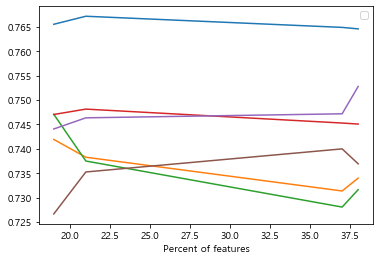

In [10]:
# 6개의 모델을 이용해서 가장 잘나온 p를 뽑을 것임

new_range = [19, 21, 37, 38]

for model in models:
    
    cv_scores_mean = []
    
    
    # 퍼센타일을 5~100프로 모두 살피기
    for percentile in tqdm(new_range):
    
        X_new = SelectPercentile(percentile = percentile).fit_transform(X_train,y_train)
       
        # cross_val_score 5번의 평균값
        cv_score = cross_val_score(model, X_new, y_train, scoring='roc_auc', cv=5)
        
        cv_scores_mean.append((percentile, cv_score.mean()))
        
        print(cv_score, cv_score.mean())
        
        # 베스트 percentile과 점수 출력
    best_score = cv_scores_mean[np.argmax([score for _, score in cv_scores_mean])]
    print(model.__class__.__name__, best_score)
    
    # 모델별 percentile에 따른 성능 그림
    plt.plot([p for p,_ in cv_scores_mean], [score for _, score in cv_scores_mean])
    plt.xlabel('Percent of features')
    plt.legend(loc=0)
    plt.grid()

In [25]:
# 4개의 구간에서 21일때 LGBM과 XGB를 빼고 다 성능이 2위이상
# LGBM과 XGB가 다른 구간과 성능차가 엄청나지 않아서 21로 결정

select_p = SelectPercentile(percentile = 21).fit(X_train, y_train)
X_train = select_p.transform(X_train)
X_test = select_p.transform(X_test)